In [136]:
import posixpath
import numpy as np
import pandas as pd
import geopandas as gpd
import distances
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy

## Load Fronts

In [137]:
data_root = "D:/OneDrive/Documents/Cours/4A/SFE/data/"

kh_fronts = gpd.read_file(posixpath.join(data_root, "KH-5_ARGON_fronts/KH-5_ARGON_fronts.shp")).to_crs(epsg=25833)
landsat_fronts = gpd.read_file(posixpath.join(data_root, "Landsat_MSS_fronts/Landsat_MSS_fronts.shp")).to_crs(epsg=25833)
npi_fronts = gpd.read_file(posixpath.join(data_root, "NPI_fronts/NPI_fronts.shp")).to_crs(epsg=25833)
all_fronts = pd.concat([npi_fronts, kh_fronts, landsat_fronts], ignore_index=True)
all_fronts.head()

,mission,timestamp,RGI60ID,RGI70ID,front_id,front_dir,geometry,image
0,NPI 1936-1938 aerial survey,1936-01-01,RGI60-07.00006,RGI2000-v7.0-G-07-00787,77,NW,"LINESTRING (532543.309 8544051.053, 532636.725...",NaN
1,NPI 1936-1938 aerial survey,1936-01-01,RGI60-07.00025,RGI2000-v7.0-G-07-01384,161,S,"LINESTRING (688874.291 8815732.222, 688441.142...",NaN
2,NPI 1936-1938 aerial survey,1936-01-01,RGI60-07.00035,RGI2000-v7.0-G-07-01365,176,E,"LINESTRING (626236.343 8902937.128, 626351.396...",NaN
3,NPI 1936-1938 aerial survey,1936-01-01,RGI60-07.00036,RGI2000-v7.0-G-07-01363,177,E,"LINESTRING (610107.299 8911853.037, 610139.55 ...",NaN
4,NPI 1936-1938 aerial survey,1936-01-01,RGI60-07.01449,RGI2000-v7.0-G-07-01343,144,NW,"LINESTRING (581931.237 8893586.913, 581984.338...",NaN


In [138]:
print(len(all_fronts.RGI70ID.value_counts()), "glaciers observed")
print(len(all_fronts.front_id.value_counts()), "fronts observed")

167 glaciers observed
185 fronts observed


## Box distance

In [139]:
boxes = gpd.read_file(posixpath.join(data_root, "boxes/boxes.shp")).to_crs(epsg=25833)
boxes.head()

,front_id,front_dir,RGI60ID,RGI70ID,geometry
0,1,NE,RGI60-07.01494,RGI2000-v7.0-G-07-00054,"POLYGON ((448958.093 8831407.133, 451132.965 8..."
1,2,NE,RGI60-07.00791,RGI2000-v7.0-G-07-01223,"POLYGON ((448556.464 8831393.624, 447609.196 8..."
2,3,E,RGI60-07.00777,RGI2000-v7.0-G-07-01225,"POLYGON ((446223.949 8833013.329, 449012.234 8..."
3,4,SE,RGI60-07.00775,RGI2000-v7.0-G-07-01229,"POLYGON ((445849.929 8838239.577, 448611.174 8..."
4,5,NE,RGI60-07.00794,RGI2000-v7.0-G-07-01268,"POLYGON ((444478.132 8842149.605, 443352.455 8..."


In [140]:
uncertainties_box = pd.read_csv("./uncertainties_box.csv", dtype={"year_1": int, "year_2": int})
uncertainties_box.loc[:, "years"] = uncertainties_box.loc[:, ["year_1", "year_2"]].apply(lambda x: (x.iloc[0], x.iloc[1]), axis=1)
uncertainties_box

,year_1,year_2,sigma_dist,2_sigma_dist,3_sigma_dist,years
0,1936,1936,29.698485,59.396970,89.095454,"(1936, 1936)"
1,1936,1962,500.440806,1000.881611,1501.322417,"(1936, 1962)"
2,1936,1963,216.023147,432.046294,648.069441,"(1936, 1963)"
3,1936,1976,98.270036,196.540072,294.810108,"(1936, 1976)"
4,1936,1978,100.224747,200.449495,300.674242,"(1936, 1978)"
5,1962,1962,707.106781,1414.213562,2121.320344,"(1962, 1962)"
6,1962,1963,544.265560,1088.531120,1632.796681,"(1962, 1963)"
7,1962,1976,509.132596,1018.265191,1527.397787,"(1962, 1976)"
8,1962,1978,509.513493,1019.026987,1528.540480,"(1962, 1978)"
9,1963,1963,304.055916,608.111832,912.167748,"(1963, 1963)"


#### General trend

In [141]:
uncertainties_box_single = pd.read_csv("./uncertainties_box_single.csv", dtype={"year": int, "sigma": int})
uncertainties_box_single

,year,sigma
0,1936,21
1,1962,500
2,1963,215
3,1976,96
4,1978,98


##### Length

In [142]:
def get_year(timestamp):
    return timestamp.year

positions_box = pd.DataFrame(
    [],
    columns = ["front_id", "year", "total_count", "skip_count", "distances", "mean", "std"]
)

fronts_list = np.sort(all_fronts.front_id.unique())
 
print("Distances calculations ...")
for front_id in fronts_list:
    front_data = all_fronts.loc[all_fronts.front_id == front_id]
    years = np.sort(front_data['timestamp'].apply(get_year).unique())

    if not boxes.loc[boxes.front_id == front_id].empty:
        box = boxes.loc[boxes.front_id == front_id].geometry.values[0]

    for year in years:
        front_data_year = front_data.loc[front_data['timestamp'].apply(get_year) == year]
        total_count = len(front_data_year)
        skip_count = 0
        dists = []
        for i in range(len(front_data_year)):
            front = front_data_year.iloc[i].geometry
            dirs = front_data_year.front_dir
            if len(dirs.unique()) == 1:
                dir = dirs.unique()[0]
                try:
                    dist, e = distances.box_measure(front, dir, box)
                    if dist is not None:
                        dists.append(dist)
                    elif e != 0:
                        skip_count += 1
                except Exception as ex:
                    print(f"front {front_id} : ")
                    print(ex)
                    skip_count += 1
            else:
                skip_count += 1
        dists = np.array(dists)
                
        results_i = pd.DataFrame(
            [],
            columns = ["front_id", "year", "total_count", "skip_count", "distances", "mean", "std"]
        )
        results_i.loc[len(results_i)] = [front_id, year, total_count, skip_count, dists, None, None]
        
        if dists.shape[0] > 0:
            results_i.loc[len(results_i) - 1, "mean"] = np.mean(dists)
        if dists.shape[0] > 1:
            results_i.loc[len(results_i) - 1, "std"] = np.std(dists)

        positions_box = pd.concat([positions_box, results_i], ignore_index=True)
        
positions_box.loc[:, "uncertainty"] = positions_box.loc[:, ["year"]].apply(lambda x: uncertainties_box_single.loc[uncertainties_box_single.year == x.iloc[0], "sigma"].values[0], axis=1)
positions_box.dropna(axis=0, subset="mean", inplace=True)
positions_box

Distances calculations ...
front 116 : 
operands could not be broadcast together with shapes (3,2) (2,2) 
front 182 : 
Unknown direction: None
front 183 : 
Unknown direction: None
front 184 : 
Unknown direction: None
front 185 : 
Unknown direction: None


,front_id,year,total_count,skip_count,distances,mean,std,uncertainty
0,1,1936,1,0,[3211.846560613241],3211.846561,None,21
1,1,1962,3,0,"[2938.9338563623846, 3688.2350543288517, 3405....",3344.199067,308.949656,500
2,1,1963,2,0,"[2873.0605978626286, 3116.2386074220553]",2994.649603,121.589005,215
3,1,1976,5,0,"[2604.52164719872, 2608.4023003573, 2512.55142...",2571.744161,35.304391,96
4,1,1978,1,0,[2620.9760204313975],2620.97602,None,98
...,...,...,...,...,...,...,...,...
652,180,1962,2,0,"[2066.0960438439097, 2313.923431750415]",2190.009738,123.913694,500
653,180,1963,2,0,"[1868.0384665298482, 2072.911729351007]",1970.475098,102.436631,215
654,180,1976,1,0,[1343.696234493521],1343.696234,None,96
655,181,1936,1,0,[1499.936425338489],1499.936425,None,21


In [143]:
for front_id in fronts_list:
    front_data = positions_box.loc[positions_box.front_id == front_id]
    if not front_data.loc[front_data.year == 1936].empty:
        front_data["mean_corrected"] = front_data["mean"] - front_data.loc[front_data.year == 1936]["mean"].values[0]
        positions_box.loc[positions_box.front_id == front_id, "mean_corrected"] = front_data["mean_corrected"]

positions_box

C:\Users\loris\AppData\Local\Temp\ipykernel_10856\791252403.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  front_data["mean_corrected"] = front_data["mean"] - front_data.loc[front_data.year == 1936]["mean"].values[0]
C:\Users\loris\AppData\Local\Temp\ipykernel_10856\791252403.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  front_data["mean_corrected"] = front_data["mean"] - front_data.loc[front_data.year == 1936]["mean"].values[0]
C:\Users\loris\AppData\Local\Temp\ipykernel_10856\791252403.py:4: Se

,front_id,year,total_count,skip_count,distances,mean,std,uncertainty,mean_corrected
0,1,1936,1,0,[3211.846560613241],3211.846561,None,21,0.0
1,1,1962,3,0,"[2938.9338563623846, 3688.2350543288517, 3405....",3344.199067,308.949656,500,132.352507
2,1,1963,2,0,"[2873.0605978626286, 3116.2386074220553]",2994.649603,121.589005,215,-217.196958
3,1,1976,5,0,"[2604.52164719872, 2608.4023003573, 2512.55142...",2571.744161,35.304391,96,-640.102399
4,1,1978,1,0,[2620.9760204313975],2620.97602,None,98,-590.87054
...,...,...,...,...,...,...,...,...,...
652,180,1962,2,0,"[2066.0960438439097, 2313.923431750415]",2190.009738,123.913694,500,-1703.263221
653,180,1963,2,0,"[1868.0384665298482, 2072.911729351007]",1970.475098,102.436631,215,-1922.797861
654,180,1976,1,0,[1343.696234493521],1343.696234,None,96,-2549.576724
655,181,1936,1,0,[1499.936425338489],1499.936425,None,21,0.0


In [144]:
mean_glaciers = positions_box.groupby("year")["mean_corrected"].mean()
mean_glaciers

year
1936            0.0
1962    -954.117225
1963   -1072.716259
1976   -1025.721124
1978   -1273.611449
Name: mean_corrected, dtype: object

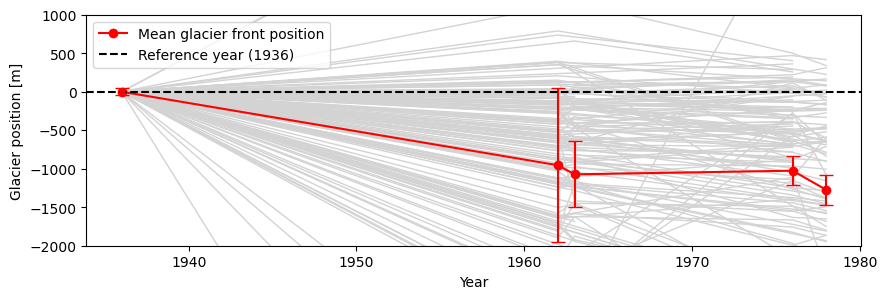

In [145]:
fig, ax = plt.subplots(figsize=[10, 3])


for front_id in fronts_list:
    ax.plot(positions_box.loc[positions_box.front_id == front_id].year, positions_box.loc[positions_box.front_id == front_id].mean_corrected, marker=" ", linestyle="-", markersize=3, color="lightgray", linewidth=1, alpha=1)
    
x = mean_glaciers.index.values.astype(int)
y = mean_glaciers.values.astype(float)
err = 2 * uncertainties_box_single.sigma.values
ax.plot(x, y, marker="o", linestyle="-", color="red", linewidth=1.5, label="Mean glacier front position")
ax.errorbar(x, y, yerr=err, fmt='o', color='red', markersize=3, capsize=5)
ax.axhline(y=0, color="k", linestyle="--", linewidth=1.5, label="Reference year (1936)")
ax.set_ylim([-2000, 1000])
ax.set_xlabel("Year")
ax.set_ylabel("Glacier position [m]")
ax.legend()
fig.savefig("images/mean_glacier_front_position_box.png", bbox_inches="tight")

In [146]:
lr = scipy.stats.linregress(x, y)
lr.slope, lr.rvalue

(-28.011057935547555, -0.942829920188545)

In [147]:
y, err

(array([    0.        ,  -954.11722507, -1072.71625902, -1025.72112381,
        -1273.61144901]),
 array([  42, 1000,  430,  192,  196]))

##### Area

In [148]:
def get_year(timestamp):
    return timestamp.year

areas_box = pd.DataFrame(
    [],
    columns = ["front_id", "year", "total_count", "skip_count", "areas", "mean", "std"]
)

fronts_list = np.sort(all_fronts.front_id.unique())
# widths = []
print("Distances calculations ...")
for front_id in fronts_list:
    front_data = all_fronts.loc[all_fronts.front_id == front_id]
    years = np.sort(front_data['timestamp'].apply(get_year).unique())

    if not boxes.loc[boxes.front_id == front_id].empty:
        box = boxes.loc[boxes.front_id == front_id].geometry.values[0]
        
    width = front_data.geometry.apply(lambda x: x.length).mean()
    # widths.append(width)
    for year in years:
        front_data_year = front_data.loc[front_data['timestamp'].apply(get_year) == year]
        total_count = len(front_data_year)
        skip_count = 0
        areas = []
        for i in range(len(front_data_year)):
            front = front_data_year.iloc[i].geometry
            dirs = front_data_year.front_dir
            if len(dirs.unique()) == 1:
                dir = dirs.unique()[0]
                try:
                    area, e = distances.box_measure(front, dir, box)
                    area = area * width if area is not None else None
                    if area is not None:
                        areas.append(area)
                    elif e != 0:
                        skip_count += 1
                except Exception as ex:
                    print(f"front {front_id} : ")
                    print(ex)
                    skip_count += 1
            else:
                skip_count += 1
        areas = np.array(areas)
                
        results_i = pd.DataFrame(
            [],
            columns = ["front_id", "year", "total_count", "skip_count", "areas", "mean", "std", "uncertainty"]
        )
        results_i.loc[len(results_i)] = [front_id, year, total_count, skip_count, areas, None, None, uncertainties_box_single.loc[uncertainties_box_single.year == year, "sigma"].values[0] * width]
        
        if areas.shape[0] > 0:
            results_i.loc[len(results_i) - 1, "mean"] = np.mean(areas)
        if areas.shape[0] > 1:
            results_i.loc[len(results_i) - 1, "std"] = np.std(areas)

        areas_box = pd.concat([areas_box, results_i], ignore_index=True)
        
# areas_box.loc[:, "uncertainty"] = areas_box.loc[:, ["year"]].apply(lambda x: uncertainties_box_single.loc[uncertainties_box_single.year == x.iloc[0], "sigma"].values[0], axis=1)
areas_box.dropna(axis=0, subset="mean", inplace=True)
areas_box

Distances calculations ...
front 116 : 
operands could not be broadcast together with shapes (3,2) (2,2) 
front 182 : 
Unknown direction: None
front 183 : 
Unknown direction: None
front 184 : 
Unknown direction: None
front 185 : 
Unknown direction: None


,front_id,year,total_count,skip_count,areas,mean,std,uncertainty
0,1,1936,1,0,[12300973.489898898],12300973.489899,None,8.042739e+04
1,1,1962,3,0,"[11255751.722080255, 14125482.264368415, 13042...",12807867.155822,1183238.817321,1.914938e+06
2,1,1963,2,0,"[11003465.321965287, 11934806.901478896]",11469136.111722,465670.789757,8.234233e+05
3,1,1976,5,0,"[9974994.487265354, 9989856.906975115, 9622759...",9849460.786112,135211.43269,3.676681e+05
4,1,1978,1,0,[10038012.693492934],10038012.693493,None,3.753278e+05
...,...,...,...,...,...,...,...,...
652,180,1962,2,0,"[6705466.284113932, 7509784.262863542]",7107625.273489,402158.989375,1.622738e+06
653,180,1963,2,0,"[6062675.059112651, 6727586.431677808]",6395130.745395,332455.686283,6.977775e+05
654,180,1976,1,0,[4360934.634831455],4360934.634831,None,3.115657e+05
655,181,1936,1,0,[1180888.2953624872],1180888.295362,None,1.653314e+04


In [149]:
for front_id in fronts_list:
    front_data = areas_box.loc[areas_box.front_id == front_id]
    if not front_data.loc[front_data.year == 1936].empty:
        front_data["mean_corrected"] = front_data["mean"] - front_data.loc[front_data.year == 1936]["mean"].values[0]
        areas_box.loc[areas_box.front_id == front_id, "mean_corrected"] = front_data["mean_corrected"]

areas_box

C:\Users\loris\AppData\Local\Temp\ipykernel_10856\1145227165.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  front_data["mean_corrected"] = front_data["mean"] - front_data.loc[front_data.year == 1936]["mean"].values[0]
C:\Users\loris\AppData\Local\Temp\ipykernel_10856\1145227165.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  front_data["mean_corrected"] = front_data["mean"] - front_data.loc[front_data.year == 1936]["mean"].values[0]
C:\Users\loris\AppData\Local\Temp\ipykernel_10856\1145227165.py:4:

,front_id,year,total_count,skip_count,areas,mean,std,uncertainty,mean_corrected
0,1,1936,1,0,[12300973.489898898],12300973.489899,None,8.042739e+04,0.0
1,1,1962,3,0,"[11255751.722080255, 14125482.264368415, 13042...",12807867.155822,1183238.817321,1.914938e+06,506893.665923
2,1,1963,2,0,"[11003465.321965287, 11934806.901478896]",11469136.111722,465670.789757,8.234233e+05,-831837.378177
3,1,1976,5,0,"[9974994.487265354, 9989856.906975115, 9622759...",9849460.786112,135211.43269,3.676681e+05,-2451512.703787
4,1,1978,1,0,[10038012.693492934],10038012.693493,None,3.753278e+05,-2262960.796406
...,...,...,...,...,...,...,...,...,...
652,180,1962,2,0,"[6705466.284113932, 7509784.262863542]",7107625.273489,402158.989375,1.622738e+06,-5527900.861479
653,180,1963,2,0,"[6062675.059112651, 6727586.431677808]",6395130.745395,332455.686283,6.977775e+05,-6240395.389572
654,180,1976,1,0,[4360934.634831455],4360934.634831,None,3.115657e+05,-8274591.500136
655,181,1936,1,0,[1180888.2953624872],1180888.295362,None,1.653314e+04,0.0


In [150]:
sum_glaciers_box = areas_box.groupby("year")["mean_corrected"].sum()
sum_glaciers_box

year
1936                 0.0
1962    -733399375.01724
1963   -580401737.713146
1976   -922181832.422728
1978   -958562542.188132
Name: mean_corrected, dtype: object

In [151]:
positions_box.isna().sum()

front_id            0
year                0
total_count         0
skip_count          0
distances           0
mean                0
std               369
uncertainty         0
mean_corrected     61
dtype: int64

In [152]:
# fig, ax = plt.subplots(figsize=[10, 3])

# ul = (uncertainties_box_single.sigma.values)**2
# widths = all_fronts.groupby("front_id").geometry.apply(lambda x: x.apply(lambda y: y.length).mean())

# ul_mesh, widths_mesh = np.meshgrid(ul, widths)
# err = 2 * np.sqrt((ul_mesh * widths_mesh).sum(axis=0))/1e6

# x = sum_glaciers_box.index.values.astype(int)
# y = sum_glaciers_box.values.astype(float)/1e6

# ax.plot(x, y, marker="o", linestyle="-", color="k", linewidth=1.5)
# ax.errorbar(x, y, yerr=err, fmt='o', color='k', markersize=3, capsize=5)
# ax.axhline(y=0, color="k", linestyle="--", linewidth=1.5, label="Reference year (1936)")

# ax.set_xlabel("Year")
# ax.set_ylabel("Cumulative area change [km²]")
# ax.legend()
# fig.savefig("images/mean_glacier_front_area_cl.png", bbox_inches="tight")

In [153]:
def get_year(timestamp):
    return timestamp.year

all_fronts["year"] = all_fronts["timestamp"].apply(get_year)

(151, 5) (5,) (151, 5) (151,)
(151, 5)
[  8.55540735 270.77582223 212.74207793 227.01012185 231.99372748]


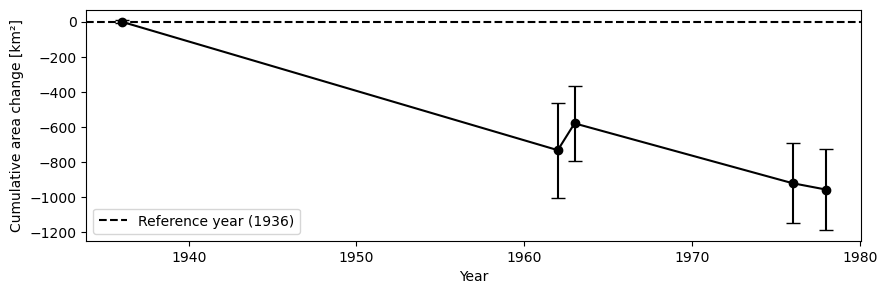

In [154]:
fig, ax = plt.subplots(figsize=[10, 3])


# Create a 2D array from positions_box using front_id as rows and year as columns, values as mean_corrected
front_ids = np.sort(positions_box.dropna(subset=["mean_corrected"]).front_id.unique())
years = np.sort(positions_box.dropna(subset=["mean_corrected"]).year.unique())
l = np.full((len(front_ids), len(years)), 0.)
w = np.full((len(front_ids), len(years)), 0.) # E(Wi^2)

front_id_to_idx = {fid: i for i, fid in enumerate(front_ids)}
year_to_idx = {y: i for i, y in enumerate(years)}

for _, row in positions_box.dropna(subset=["mean_corrected"]).iterrows():
    i = front_id_to_idx[row.front_id]
    j = year_to_idx[row.year]
    l[i, j] = row.mean_corrected**2

for _, row in positions_box.dropna(subset=["mean_corrected"]).iterrows():
    id, year = row.front_id, row.year
    i = front_id_to_idx[id]
    j = year_to_idx[year]
    w[i, j] = all_fronts.loc[all_fronts.front_id == id].loc[all_fronts.year == year].geometry.apply(lambda x: x.length**2).mean()

# w.shape
ul = (uncertainties_box_single.sigma.values)**2 # V(Di)
uw = (all_fronts.loc[all_fronts.front_id.isin(front_ids)].groupby(["front_id"]).geometry.apply(lambda x: x.apply(lambda y: y.length).std()))**2 # V(Wi)
print(l.shape, ul.shape, w.shape, uw.shape)

ul_mesh, w_mesh = np.meshgrid(ul, w)
err1 = (ul_mesh * w_mesh).sum(axis=0)
# print(err1)

uw_stack = np.array([uw for _ in range(l.shape[1])]).T
print(uw_stack.shape)
err2 = (l * uw_stack).sum(axis=0)
err = 2 * np.sqrt(err1 + err2)/1e6

# # print((l * uw_stack))
# print(err2)
print(err)

x = sum_glaciers_box.index.values.astype(int)
y = sum_glaciers_box.values.astype(float)/1e6

ax.plot(x, y, marker="o", linestyle="-", color="k", linewidth=1.5)
ax.errorbar(x, y, yerr=err, fmt='o', color='k', markersize=3, capsize=5)
ax.axhline(y=0, color="k", linestyle="--", linewidth=1.5, label="Reference year (1936)")

ax.set_xlabel("Year")
ax.set_ylabel("Cumulative area change [km²]")
ax.legend()
fig.savefig("images/mean_glacier_front_area_box.png", bbox_inches="tight")

In [155]:
lr = scipy.stats.linregress(x, y)
lr.slope, lr.rvalue**2

(-22.805518308985945, 0.9694929335093412)

In [156]:
y, err

(array([   0.        , -733.39937502, -580.40173771, -922.18183242,
        -958.56254219]),
 array([  8.55540735, 270.77582223, 212.74207793, 227.01012185,
        231.99372748]))

#### Identification of specific events

In [157]:
def get_year(timestamp):
    return timestamp.year

results_box = pd.DataFrame(
    [],
    columns = ["front_id", "year_1", "year_2", "distance"]
)
total_count = 0
skip_count = 0
years = [1936, 1962, 1963, 1976, 1978]

for front in all_fronts.front_id.unique():
    # compare observations from any year to fronts from any other year, for a specific front.
    for i_year in range(len(years) - 1):
        year = years[i_year]
        fronts = all_fronts.loc[all_fronts.front_id == front].loc[all_fronts.timestamp.apply(get_year) == year]
        for i_other_year in range(i_year + 1, len(years)):
            other_year = years[i_other_year]
            other_fronts = all_fronts.loc[all_fronts.front_id == front].loc[all_fronts.timestamp.apply(get_year) == other_year]
            
            dists = []
            # compare all the observations between them
            for k in range(len(fronts.geometry)):
                for l in range(len(other_fronts.geometry)):
                    front1 = fronts.geometry.iloc[k]
                    front2 = other_fronts.geometry.iloc[l]
                    dir_1 = fronts.front_dir.iloc[k]
                    dir_2 = other_fronts.front_dir.iloc[l]
                    try:
                        if not boxes.loc[boxes.front_id == fronts.front_id.iloc[k]].empty:
                            box = boxes.loc[boxes.front_id == fronts.front_id.iloc[k]].geometry.values[0]
                            dist, e = distances.box_distance(front1, front2, box, dir_1, dir_2)
                            if dist is not None:
                                dists.append(dist)
                            elif e == 1:
                                skip_count += 1
                        else:
                            skip_count += 1
                    except AssertionError:
                        skip_count += 1
                    total_count += 1
            
            if not dists == []:
                # horrible hack to load an array as a value in a DataFrame
                results_i = pd.DataFrame(
                    [[front, year, other_year, np.array(dists)]],
                    columns=["front_id", "year_1", "year_2", "distance"]
                )      
            else: # load None instead of a list of distances
                results_i = pd.DataFrame(
                    [[front, year, other_year, None]],
                    columns=["front_id", "year_1", "year_2", "distance"]
                )
            results_box = pd.concat([results_box, results_i])
            
print(f"Skipped {skip_count} comparisons out of {total_count}.")
results_box.reset_index(drop=True, inplace=True)
results_box = results_box.dropna().reset_index(drop=True)


results_box.loc[:, "mean_distance"] = results_box.distance.apply(lambda x: np.array(x).mean())
results_box.loc[:, "uncertainty"] = results_box.loc[:, ["year_1", "year_2"]].apply(lambda x: uncertainties_box.loc[(uncertainties_box.year_1 == x.iloc[0]) & (uncertainties_box.year_2 == x.iloc[1]), "2_sigma_dist"].values[0], axis=1)

# not necessary but easier to control results : put the years in a single column. 
results_box.loc[:, "years"] = results_box.loc[:, ["year_1", "year_2"]].apply(lambda x: (x.iloc[0], x.iloc[1]), axis=1)
results_box = results_box[["front_id", "year_1", "year_2", "years", "distance", "mean_distance", "uncertainty"]]

results_box

Skipped 738 comparisons out of 2967.


,front_id,year_1,year_2,years,distance,mean_distance,uncertainty
0,77,1936,1962,"(1936, 1962)","[-1242.5244095968242, -1108.137981874091]",-1175.331196,1000.881611
1,77,1936,1976,"(1936, 1976)",[-1374.9205411934863],-1374.920541,196.540072
2,77,1936,1978,"(1936, 1978)",[-1419.501964673488],-1419.501965,200.449495
3,77,1962,1976,"(1962, 1976)","[-132.3961315966622, -266.78255931939503]",-199.589345,1018.265191
4,77,1962,1978,"(1962, 1978)","[-176.9775550766638, -311.36398279939664]",-244.170769,1019.026987
...,...,...,...,...,...,...,...
834,165,1962,1976,"(1962, 1976)","[-367.6942015637037, -361.95752751003596, -161...",-414.344392,1018.265191
835,165,1962,1978,"(1962, 1978)","[-72.23986565169943, 133.93433507317275, -1978...",-121.758393,1019.026987
836,165,1976,1978,"(1976, 1978)","[295.45433591200424, 289.71766185833656]",292.585999,274.372010
837,168,1962,1978,"(1962, 1978)","[916.0482169934909, -288.39078112381566, -763....",-347.129713,1019.026987


100 -0.9541172250659319 1.405636644297813
76 -1.0727162590197563 1.5711465500305488
130 -1.0304059288408622 1.5352175205940202
90 -1.2726197728582163 1.691369413563186
56 -0.012116049936165916 0.2859727774251891
103 -0.2893528460581797 0.8146306037446931
75 -0.35366402350025544 1.0196691131263351
70 -0.29418813612170375 0.9655853180853801
50 -0.26692882817994945 1.0918673067750018
89 -0.08737393087527791 0.21699131025661922


C:\Users\loris\AppData\Local\Temp\ipykernel_10856\1757479618.py:170: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[i, j].set_yticklabels(axs[i, j].get_yticks().astype(int))
C:\Users\loris\AppData\Local\Temp\ipykernel_10856\1757479618.py:170: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[i, j].set_yticklabels(axs[i, j].get_yticks().astype(int))
C:\Users\loris\AppData\Local\Temp\ipykernel_10856\1757479618.py:170: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[i, j].set_yticklabels(axs[i, j].get_yticks().astype(int))
C:\Users\loris\AppData\Local\Temp\ipykernel_10856\1757479618.py:170: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[i, j].set_ytic

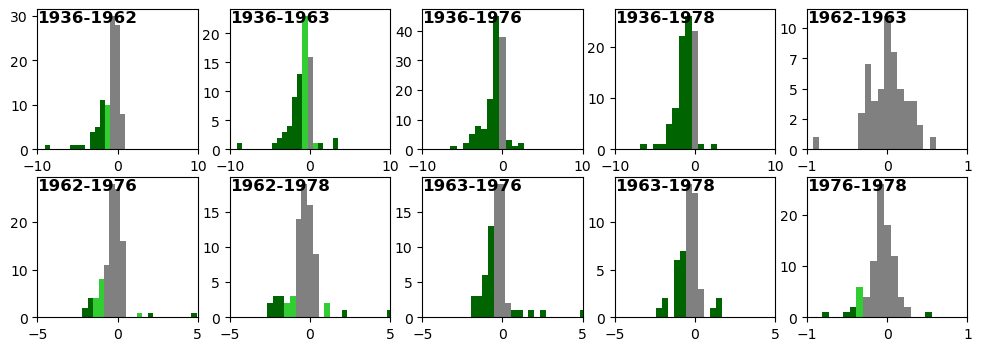

In [158]:
fig, axs = plt.subplots(ncols=5, nrows=2, figsize=(12, 4))

color_sigma = "gray"
color_2_sigma = "limegreen"
color_3_sigma = "darkgreen"
nbins = 30

years = (1936, 1962)
d = results_box.loc[results_box.years == years].mean_distance/1e3
N, bins, patches = axs[0, 0].hist(d, color="gray", bins=np.linspace(-np.abs(d).max(), np.abs(d).max(), nbins))
sigma = uncertainties_box.loc[uncertainties_box.years == years]["sigma_dist"].values[0]/1e3
bins = np.array(bins) + (bins[1] - bins[0])/2  # shift bins to the center
for i in range(len(patches)):
    if np.abs(bins[i]) >= sigma:
        patches[i].set_facecolor(color_sigma)
    if np.abs(bins[i]) >= 2 * sigma:
        patches[i].set_facecolor(color_2_sigma)
    if np.abs(bins[i]) >= 3 * sigma:
        patches[i].set_facecolor(color_3_sigma)
axs[0, 0].set_title(f"{years[0]}-{years[1]}", y=0.85, loc="left", fontweight="semibold")
axs[0, 0].set_xlim(-10, 10)
print(d.shape[0], d.mean(), d.std())

years = (1936, 1963)
d = results_box.loc[results_box.years == years].mean_distance/1e3
N, bins, patches = axs[0, 1].hist(d, color="gray", bins=np.linspace(-np.abs(d).max(), np.abs(d).max(), nbins))
sigma = uncertainties_box.loc[uncertainties_box.years == years]["sigma_dist"].values[0]/1e3
bins = np.array(bins) + (bins[1] - bins[0])/2  # shift bins to the center
for i in range(len(patches)):
    if np.abs(bins[i]) >= sigma:
        patches[i].set_facecolor(color_sigma)
    if np.abs(bins[i]) >= 2 * sigma:
        patches[i].set_facecolor(color_2_sigma)
    if np.abs(bins[i]) >= 3 * sigma:
        patches[i].set_facecolor(color_3_sigma)
axs[0, 1].set_title(f"{years[0]}-{years[1]}", y=0.85, loc="left", fontweight="semibold")
axs[0, 1].set_xlim(-10, 10)
print(d.shape[0], d.mean(), d.std())

years = (1936, 1976)
d = results_box.loc[results_box.years == years].mean_distance/1e3
N, bins, patches = axs[0, 2].hist(d, color="gray", bins=np.linspace(-np.abs(d).max(), np.abs(d).max(), nbins))
sigma = uncertainties_box.loc[uncertainties_box.years == years]["sigma_dist"].values[0]/1e3
bins = np.array(bins) + (bins[1] - bins[0])/2  # shift bins to the center
for i in range(len(patches)):
    if np.abs(bins[i]) >= sigma:
        patches[i].set_facecolor(color_sigma)
    if np.abs(bins[i]) >= 2 * sigma:
        patches[i].set_facecolor(color_2_sigma)
    if np.abs(bins[i]) >= 3 * sigma:
        patches[i].set_facecolor(color_3_sigma)
axs[0, 2].set_title(f"{years[0]}-{years[1]}", y=0.85, loc="left", fontweight="semibold")
axs[0, 2].set_xlim(-10, 10)
print(d.shape[0], d.mean(), d.std())

years = (1936, 1978)
d = results_box.loc[results_box.years == years].mean_distance/1e3
N, bins, patches = axs[0, 3].hist(d, color="gray", bins=np.linspace(-np.abs(d).max(), np.abs(d).max(), nbins))
sigma = uncertainties_box.loc[uncertainties_box.years == years]["sigma_dist"].values[0]/1e3
bins = np.array(bins) + (bins[1] - bins[0])/2  # shift bins to the center
for i in range(len(patches)):
    if np.abs(bins[i]) >= sigma:
        patches[i].set_facecolor(color_sigma)
    if np.abs(bins[i]) >= 2 * sigma:
        patches[i].set_facecolor(color_2_sigma)
    if np.abs(bins[i]) >= 3 * sigma:
        patches[i].set_facecolor(color_3_sigma)
axs[0, 3].set_title(f"{years[0]}-{years[1]}", y=0.85, loc="left", fontweight="semibold")
axs[0, 3].set_xlim(-10, 10)
print(d.shape[0], d.mean(), d.std())

years = (1962, 1963)
d = results_box.loc[results_box.years == years].mean_distance/1e3
N, bins, patches = axs[0, 4].hist(d, color="gray", bins=np.linspace(-np.abs(d).max(), np.abs(d).max(), nbins))
sigma = uncertainties_box.loc[uncertainties_box.years == years]["sigma_dist"].values[0]/1e3
bins = np.array(bins) + (bins[1] - bins[0])/2  # shift bins to the center
for i in range(len(patches)):
    if np.abs(bins[i]) >= sigma:
        patches[i].set_facecolor(color_sigma)
    if np.abs(bins[i]) >= 2 * sigma:
        patches[i].set_facecolor(color_2_sigma)
    if np.abs(bins[i]) >= 3 * sigma:
        patches[i].set_facecolor(color_3_sigma)
axs[0, 4].set_title(f"{years[0]}-{years[1]}", y=0.85, loc="left", fontweight="semibold")
axs[0, 4].set_xlim(-1, 1)
print(d.shape[0], d.mean(), d.std())
        
years = (1962, 1976)
d = results_box.loc[results_box.years == years].mean_distance/1e3
N, bins, patches = axs[1, 0].hist(d, color="gray", bins=np.linspace(-np.abs(d).max(), np.abs(d).max(), nbins))
sigma = uncertainties_box.loc[uncertainties_box.years == years]["sigma_dist"].values[0]/1e3
bins = np.array(bins) + (bins[1] - bins[0])/2
for i in range(len(patches)):
    if np.abs(bins[i]) >= sigma:
        patches[i].set_facecolor(color_sigma)
    if np.abs(bins[i]) >= 2 * sigma:
        patches[i].set_facecolor(color_2_sigma)
    if np.abs(bins[i]) >= 3 * sigma:
        patches[i].set_facecolor(color_3_sigma)
axs[1, 0].set_title(f"{years[0]}-{years[1]}", y=0.85, loc="left", fontweight="semibold")
axs[1, 0].set_xlim(-5, 5)
print(d.shape[0], d.mean(), d.std())
        
years = (1962, 1978)
d = results_box.loc[results_box.years == years].mean_distance/1e3
N, bins, patches = axs[1, 1].hist(d, color="gray", bins=np.linspace(-np.abs(d).max(), np.abs(d).max(), nbins))
sigma = uncertainties_box.loc[uncertainties_box.years == years]["sigma_dist"].values[0]/1e3
bins = np.array(bins) + (bins[1] - bins[0])/2
for i in range(len(patches)):
    if np.abs(bins[i]) >= sigma:
        patches[i].set_facecolor(color_sigma)
    if np.abs(bins[i]) >= 2 * sigma:
        patches[i].set_facecolor(color_2_sigma)
    if np.abs(bins[i]) >= 3 * sigma:
        patches[i].set_facecolor(color_3_sigma)
axs[1, 1].set_title(f"{years[0]}-{years[1]}", y=0.85, loc="left", fontweight="semibold")
axs[1, 1].set_xlim(-5, 5)
print(d.shape[0], d.mean(), d.std())
        
years = (1963, 1976)
d = results_box.loc[results_box.years == years].mean_distance/1e3
N, bins, patches = axs[1, 2].hist(d, color="gray", bins=np.linspace(-np.abs(d).max(), np.abs(d).max(), nbins))
sigma = uncertainties_box.loc[uncertainties_box.years == years]["sigma_dist"].values[0]/1e3
bins = np.array(bins) + (bins[1] - bins[0])/2
for i in range(len(patches)):
    if np.abs(bins[i]) >= sigma:
        patches[i].set_facecolor(color_sigma)
    if np.abs(bins[i]) >= 2 * sigma:
        patches[i].set_facecolor(color_2_sigma)
    if np.abs(bins[i]) >= 3 * sigma:
        patches[i].set_facecolor(color_3_sigma)
axs[1, 2].set_title(f"{years[0]}-{years[1]}", y=0.85, loc="left", fontweight="semibold")
axs[1, 2].set_xlim(-5, 5)
print(d.shape[0], d.mean(), d.std())
        
years = (1963, 1978)
d = results_box.loc[results_box.years == years].mean_distance/1e3
N, bins, patches = axs[1, 3].hist(d, color="gray", bins=np.linspace(-np.abs(d).max(), np.abs(d).max(), nbins))
sigma = uncertainties_box.loc[uncertainties_box.years == years]["sigma_dist"].values[0]/1e3
bins = np.array(bins) + (bins[1] - bins[0])/2
for i in range(len(patches)):
    if np.abs(bins[i]) >= sigma:
        patches[i].set_facecolor(color_sigma)
    if np.abs(bins[i]) >= 2 * sigma:
        patches[i].set_facecolor(color_2_sigma)
    if np.abs(bins[i]) >= 3 * sigma:
        patches[i].set_facecolor(color_3_sigma)
axs[1, 3].set_title(f"{years[0]}-{years[1]}", y=0.85, loc="left", fontweight="semibold")
axs[1, 3].set_xlim(-5, 5)
print(d.shape[0], d.mean(), d.std())
        
years = (1976, 1978)
d = results_box.loc[results_box.years == years].mean_distance/1e3
N, bins, patches = axs[1, 4].hist(d, color="gray", bins=np.linspace(-np.abs(d).max(), np.abs(d).max(), nbins))
sigma = uncertainties_box.loc[uncertainties_box.years == years]["sigma_dist"].values[0]/1e3
bins = np.array(bins) + (bins[1] - bins[0])/2
for i in range(len(patches)):
    if np.abs(bins[i]) >= sigma:
        patches[i].set_facecolor(color_sigma)
    if np.abs(bins[i]) >= 2 * sigma:
        patches[i].set_facecolor(color_2_sigma)
    if np.abs(bins[i]) >= 3 * sigma:
        patches[i].set_facecolor(color_3_sigma)
axs[1, 4].set_title(f"{years[0]}-{years[1]}", y=0.85, loc="left", fontweight="semibold")
axs[1, 4].set_xlim(-1, 1)
print(d.shape[0], d.mean(), d.std())

for i in range(2):
    for j in range(5):
        axs[i, j].set_yticklabels(axs[i, j].get_yticks().astype(int))
fig.savefig("images/results_distances_distributions_box_with_NPI.png", bbox_inches="tight")

In [159]:
# list of surges and retreats

surges_box = pd.DataFrame(
    [],
    columns=["front_id", "years", "mean_distance", "uncertainty"]
)

retreats_box = pd.DataFrame(
    [],
    columns=["front_id", "years", "mean_distance", "uncertainty"]
)

for years in [(1936, 1962),
              (1936, 1963),
              (1936, 1976),
              (1936, 1978),
              (1962, 1963), 
              (1962, 1976), 
              (1962, 1978), 
              (1963, 1976), 
              (1963, 1978), 
              (1976, 1978)]:
    # print("years :", years)
    sigma = uncertainties_box.loc[uncertainties_box.years == years]["sigma_dist"].values[0]
    res = results_box.where(results_box.loc[results_box.years == years, "mean_distance"].apply(lambda x: np.abs(x) >= 2 * sigma)).dropna().loc[:, ["front_id", "years", "mean_distance", "uncertainty"]]
    # print(res)
    surges_1 = res.where(res.mean_distance.apply(lambda x: x >= 0)).dropna()
    retreats_1 = res.where(res.mean_distance.apply(lambda x: x < 0)).dropna()
    if not surges_1.empty:
        surges_box = pd.concat([surges_box, surges_1])
    if not retreats_1.empty:
        retreats_box = pd.concat([retreats_box, retreats_1])
        
surges_box

C:\Users\loris\AppData\Local\Temp\ipykernel_10856\1719078495.py:32: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  retreats_box = pd.concat([retreats_box, retreats_1])
C:\Users\loris\AppData\Local\Temp\ipykernel_10856\1719078495.py:30: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  surges_box = pd.concat([surges_box, surges_1])


,front_id,years,mean_distance,uncertainty
175,50,"(1936, 1963)",1163.262446,432.046294
362,3,"(1936, 1963)",658.621812,432.046294
476,139,"(1936, 1963)",3124.432226,432.046294
515,141,"(1936, 1963)",3089.557820,432.046294
160,172,"(1936, 1976)",403.216706,196.540072
176,50,"(1936, 1976)",500.015784,196.540072
260,173,"(1936, 1976)",286.875847,196.540072
363,3,"(1936, 1976)",256.468510,196.540072
409,125,"(1936, 1976)",469.071196,196.540072
477,139,"(1936, 1976)",2225.967410,196.540072


In [160]:
retreats_box

,front_id,years,mean_distance,uncertainty
0,77,"(1936, 1962)",-1175.331196,1000.881611
52,69,"(1936, 1962)",-3064.133817,1000.881611
58,67,"(1936, 1962)",-1120.141471,1000.881611
67,68,"(1936, 1962)",-1644.002882,1000.881611
91,81,"(1936, 1962)",-1013.061123,1000.881611
...,...,...,...,...
218,53,"(1976, 1978)",-313.736313,274.372010
436,109,"(1976, 1978)",-502.040185,274.372010
577,43,"(1976, 1978)",-286.790089,274.372010
587,37,"(1976, 1978)",-332.779324,274.372010


In [161]:
# list of all fronts that either surged or retreated with >95% accuracy
len(surges_box.front_id.unique()), surges_box.front_id.unique(), len(retreats_box.front_id.unique()), retreats_box.front_id.unique()

(18,
 array([50, 3, 139, 141, 172, 173, 125, 157, 122, 175, 64, 56, 121, 93, 92,
        91, 120, 165], dtype=object),
 128,
 array([77, 69, 67, 68, 81, 100, 101, 96, 60, 61, 105, 180, 51, 39, 34, 54,
        31, 30, 109, 111, 113, 114, 140, 106, 122, 120, 57, 56, 42, 58,
        121, 138, 161, 103, 99, 93, 92, 52, 41, 53, 38, 137, 29, 27, 26,
        136, 112, 115, 178, 142, 43, 37, 28, 35, 46, 47, 48, 181, 91, 110,
        124, 150, 144, 153, 160, 66, 71, 72, 87, 80, 65, 89, 90, 40, 33,
        32, 18, 23, 21, 16, 14, 1, 4, 6, 5, 134, 126, 127, 8, 9, 12, 11, 2,
        133, 7, 10, 15, 17, 19, 20, 22, 24, 55, 78, 82, 88, 119, 143, 145,
        149, 146, 86, 49, 83, 154, 84, 116, 158, 62, 73, 74, 95, 75, 76,
        97, 50, 139, 141], dtype=object))

## Centerline method

In [162]:
centerlines = gpd.read_file(posixpath.join(data_root, "centerlines/centerlines.shp")).to_crs(epsg=25833)
centerlines.head()

,front_id,front_dir,RGI60ID,RGI70ID,geometry
0,73,S,RGI60-07.00324,RGI2000-v7.0-G-07-01545,"LINESTRING (534321.434 8546768.732, 534362.547..."
1,68,SE,RGI60-07.00244,RGI2000-v7.0-G-07-01541,"LINESTRING (521713.665 8552295.499, 521056.825..."
2,61,NW,RGI60-07.00235,RGI2000-v7.0-G-07-00899,"LINESTRING (522358.058 8605537.509, 522635.212..."
3,96,SE,RGI60-07.00422,RGI2000-v7.0-G-07-00916,"LINESTRING (560900.741 8615217.504, 561141.212..."
4,1,NE,RGI60-07.01494,RGI2000-v7.0-G-07-00054,"LINESTRING (449615.704 8824196.706, 449565.438..."


In [163]:
uncertainties_cl = pd.read_csv("./uncertainties_cl.csv", dtype={"year_1": int, "year_2": int})
uncertainties_cl.loc[:, "years"] = uncertainties_cl.loc[:, ["year_1", "year_2"]].apply(lambda x: (x.iloc[0], x.iloc[1]), axis=1)
uncertainties_cl

,year_1,year_2,sigma_dist,2_sigma_dist,3_sigma_dist,years
0,1936,1936,29.698485,59.396970,89.095454,"(1936, 1936)"
1,1936,1962,360.611980,721.223960,1081.835940,"(1936, 1962)"
2,1936,1963,182.214160,364.428319,546.642479,"(1936, 1963)"
3,1936,1976,134.647688,269.295377,403.943065,"(1936, 1976)"
4,1936,1978,73.082146,146.164291,219.246437,"(1936, 1978)"
5,1962,1962,509.116882,1018.233765,1527.350647,"(1962, 1962)"
6,1962,1963,402.940442,805.880884,1208.821327,"(1962, 1963)"
7,1962,1976,383.782490,767.564981,1151.347471,"(1962, 1976)"
8,1962,1978,366.742416,733.484833,1100.227249,"(1962, 1978)"
9,1963,1963,255.972655,511.945310,767.917964,"(1963, 1963)"


#### General Trend

In [164]:
uncertainties_cl_single = pd.read_csv("./uncertainties_cl_single.csv", dtype={"year": int, "sigma": int})
uncertainties_cl_single

,year,sigma
0,1936,21
1,1962,360
2,1963,181
3,1976,133
4,1978,70


##### Length

In [165]:
def get_year(timestamp):
    return timestamp.year

positions_cl = pd.DataFrame(
    [],
    columns = ["front_id", "year", "total_count", "skip_count", "distances", "mean", "std"]
)

fronts_list = np.sort(all_fronts.front_id.unique())
 
print("Distances calculations ...")
for front_id in fronts_list:
    front_data = all_fronts.loc[all_fronts.front_id == front_id]
    years = np.sort(front_data['timestamp'].apply(get_year).unique())

    if not centerlines.loc[centerlines.front_id == front_id].empty:
        cl = centerlines.loc[centerlines.front_id == front_id].geometry.values[0]

    for year in years:
        front_data_year = front_data.loc[front_data['timestamp'].apply(get_year) == year]
        total_count = len(front_data_year)
        skip_count = 0
        dists = []
        for i in range(len(front_data_year)):
            front = front_data_year.iloc[i].geometry
            dirs = front_data_year.front_dir
            if len(dirs.unique()) == 1:
                dir = dirs.unique()[0]
                try:
                    dist, e = distances.curvilinear_measure(front, dir, cl)
                    if dist is not None:
                        dists.append(dist)
                    elif e != 0:
                        skip_count += 1
                except Exception as ex:
                    print(f"front {front_id} : ")
                    print(ex)
                    skip_count += 1
            else:
                skip_count += 1
        dists = np.array(dists)
                
        results_i = pd.DataFrame(
            [],
            columns = ["front_id", "year", "total_count", "skip_count", "distances", "mean", "std"]
        )
        results_i.loc[len(results_i)] = [front_id, year, total_count, skip_count, dists, None, None]
        
        if dists.shape[0] > 0:
            results_i.loc[len(results_i) - 1, "mean"] = np.mean(dists)
        if dists.shape[0] > 1:
            results_i.loc[len(results_i) - 1, "std"] = np.std(dists)

        positions_cl = pd.concat([positions_cl, results_i], ignore_index=True)

positions_cl.loc[:, "uncertainty"] = positions_cl.loc[:, ["year"]].apply(lambda x: uncertainties_cl_single.loc[uncertainties_cl_single.year == x.iloc[0], "sigma"].values[0], axis=1)
positions_cl.dropna(axis=0, subset="mean", inplace=True)
positions_cl

Distances calculations ...
front 182 : 
Unknown direction: None
front 183 : 
Unknown direction: None
front 184 : 
Unknown direction: None
front 185 : 
Unknown direction: None


,front_id,year,total_count,skip_count,distances,mean,std,uncertainty
0,1,1936,1,0,[5402.0804446565235],5402.080445,None,21
1,1,1962,3,0,"[5097.228454535443, 5847.68916336003, 5601.466...",5515.461242,312.351775,360
2,1,1963,2,0,"[5066.0125692132615, 5400.471174483019]",5233.241872,167.229303,181
3,1,1976,5,0,"[4965.368576433867, 5003.784979230082, 4946.45...",4971.494988,25.55184,133
4,1,1978,1,0,[4947.088238509239],4947.088239,None,70
...,...,...,...,...,...,...,...,...
652,180,1962,2,0,"[4120.942070001364, 3955.8462368659343]",4038.394153,82.547917,360
653,180,1963,2,0,"[3719.521923230753, 3932.9755785947905]",3826.248751,106.726828,181
654,180,1976,1,0,[3278.7504276716654],3278.750428,None,133
655,181,1936,1,0,[1479.0702844616903],1479.070284,None,21


In [166]:
for front_id in fronts_list:
    front_data = positions_cl.loc[positions_cl.front_id == front_id]
    if not front_data.loc[front_data.year == 1936].empty:
        front_data["mean_corrected"] = front_data["mean"] - front_data.loc[front_data.year == 1936]["mean"].values[0]
        positions_cl.loc[positions_cl.front_id == front_id, "mean_corrected"] = front_data["mean_corrected"]

positions_cl

C:\Users\loris\AppData\Local\Temp\ipykernel_10856\2222153882.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  front_data["mean_corrected"] = front_data["mean"] - front_data.loc[front_data.year == 1936]["mean"].values[0]
C:\Users\loris\AppData\Local\Temp\ipykernel_10856\2222153882.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  front_data["mean_corrected"] = front_data["mean"] - front_data.loc[front_data.year == 1936]["mean"].values[0]
C:\Users\loris\AppData\Local\Temp\ipykernel_10856\2222153882.py:4:

,front_id,year,total_count,skip_count,distances,mean,std,uncertainty,mean_corrected
0,1,1936,1,0,[5402.0804446565235],5402.080445,None,21,0.0
1,1,1962,3,0,"[5097.228454535443, 5847.68916336003, 5601.466...",5515.461242,312.351775,360,113.380798
2,1,1963,2,0,"[5066.0125692132615, 5400.471174483019]",5233.241872,167.229303,181,-168.838573
3,1,1976,5,0,"[4965.368576433867, 5003.784979230082, 4946.45...",4971.494988,25.55184,133,-430.585457
4,1,1978,1,0,[4947.088238509239],4947.088239,None,70,-454.992206
...,...,...,...,...,...,...,...,...,...
652,180,1962,2,0,"[4120.942070001364, 3955.8462368659343]",4038.394153,82.547917,360,-1268.970911
653,180,1963,2,0,"[3719.521923230753, 3932.9755785947905]",3826.248751,106.726828,181,-1481.116313
654,180,1976,1,0,[3278.7504276716654],3278.750428,None,133,-2028.614637
655,181,1936,1,0,[1479.0702844616903],1479.070284,None,21,0.0


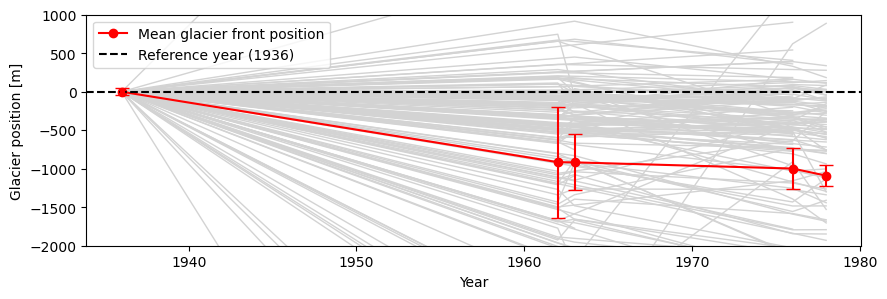

In [167]:
mean_glaciers = positions_cl.groupby("year")["mean_corrected"].mean()

fig, ax = plt.subplots(figsize=[10, 3])
for front_id in fronts_list:
    ax.plot(positions_cl.loc[positions_cl.front_id == front_id].year, positions_cl.loc[positions_cl.front_id == front_id].mean_corrected, marker=" ", linestyle="-", markersize=3, color="lightgray", linewidth=1, alpha=1)

x = mean_glaciers.index.values.astype(int)
y = mean_glaciers.values.astype(float)
err = 2 * uncertainties_cl_single.sigma.values
ax.plot(x, y, marker="o", linestyle="-", color="red", linewidth=1.5, label="Mean glacier front position")
ax.errorbar(x, y, yerr=err, fmt='o', color='red', markersize=3, capsize=5)
ax.axhline(y=0, color="k", linestyle="--", linewidth=1.5, label="Reference year (1936)")
ax.set_ylim([-2000, 1000])
ax.set_xlabel("Year")
ax.set_ylabel("Glacier position [m]")
ax.legend()
fig.savefig("images/mean_glacier_front_position_cl.png", bbox_inches="tight")

In [168]:
lr = scipy.stats.linregress(x, y)
lr.slope, lr.rvalue

(-25.27349542214601, -0.9538708230041474)

In [169]:
y, err

(array([    0.        ,  -915.0941935 ,  -917.47408158,  -997.55144128,
        -1090.28895409]),
 array([ 42, 720, 362, 266, 140]))

##### Area

In [170]:
def get_year(timestamp):
    return timestamp.year

areas_cl = pd.DataFrame(
    [],
    columns = ["front_id", "year", "total_count", "skip_count", "areas", "mean", "std"]
)

fronts_list = np.sort(all_fronts.front_id.unique())
print("Distances calculations ...")
for front_id in fronts_list:
    front_data = all_fronts.loc[all_fronts.front_id == front_id]
    years = np.sort(front_data['timestamp'].apply(get_year).unique())

    if not centerlines.loc[centerlines.front_id == front_id].empty:
        cl = centerlines.loc[centerlines.front_id == front_id].geometry.values[0]
        
    width = front_data.geometry.apply(lambda x: x.length).mean()
    
    for year in years:
        front_data_year = front_data.loc[front_data['timestamp'].apply(get_year) == year]
        total_count = len(front_data_year)
        skip_count = 0
        areas = []
        for i in range(len(front_data_year)):
            front = front_data_year.iloc[i].geometry
            dirs = front_data_year.front_dir
            if len(dirs.unique()) == 1:
                dir = dirs.unique()[0]
                try:
                    area, e = distances.curvilinear_measure(front, dir, cl)
                    if area is not None:
                        area = area * width
                        areas.append(area)
                    elif e != 0:
                        skip_count += 1
                except Exception as ex:
                    print(f"front {front_id} : ")
                    print(ex)
                    skip_count += 1
            else:
                skip_count += 1
        areas = np.array(areas)

        results_i = pd.DataFrame(
            [],
            columns = ["front_id", "year", "total_count", "skip_count", "areas", "mean", "std", "uncertainty"]
        )
        results_i.loc[len(results_i)] = [front_id, year, total_count, skip_count, areas, None, None, uncertainties_cl_single.loc[uncertainties_cl_single.year == year, "sigma"].values[0] * width]
        
        if areas.shape[0] > 0:
            results_i.loc[len(results_i) - 1, "mean"] = np.mean(areas)
        if areas.shape[0] > 1:
            results_i.loc[len(results_i) - 1, "std"] = np.std(areas)

        areas_cl = pd.concat([areas_cl, results_i], ignore_index=True)
        
areas_cl.dropna(axis=0, subset="mean", inplace=True)
areas_cl

Distances calculations ...
front 182 : 
Unknown direction: None
front 183 : 
Unknown direction: None
front 184 : 
Unknown direction: None
front 185 : 
Unknown direction: None


,front_id,year,total_count,skip_count,areas,mean,std,uncertainty
0,1,1936,1,0,[20689297.289262045],20689297.289262,None,8.042739e+04
1,1,1962,3,0,"[19521752.02268295, 22395923.34757321, 2145291...",21123531.665474,1196268.510185,1.378755e+06
2,1,1963,2,0,"[19402199.058191843, 20683133.984331757]",20042666.521262,640467.46307,6.932075e+05
3,1,1976,5,0,"[19016745.063508943, 19163875.115787435, 18944...",19040208.45925,97860.376047,5.093735e+05
4,1,1978,1,0,[18946733.639253885],18946733.639254,None,2.680913e+05
...,...,...,...,...,...,...,...,...
652,180,1962,2,0,"[13374420.899509957, 12838606.242666753]",13106513.571088,267907.328422,1.168372e+06
653,180,1963,2,0,"[12071621.22184998, 12764380.057301562]",12418000.639576,346379.417726,5.874313e+05
654,180,1976,1,0,[10641107.664033387],10641107.664033,None,4.316484e+05
655,181,1936,1,0,[1164460.5447495],1164460.544749,None,1.653314e+04


In [171]:
for front_id in fronts_list:
    front_data = areas_cl.loc[areas_cl.front_id == front_id]
    if not front_data.loc[front_data.year == 1936].empty:
        front_data["mean_corrected"] = front_data["mean"] - front_data.loc[front_data.year == 1936]["mean"].values[0]
        areas_cl.loc[areas_cl.front_id == front_id, "mean_corrected"] = front_data["mean_corrected"]

areas_cl

C:\Users\loris\AppData\Local\Temp\ipykernel_10856\3873227981.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  front_data["mean_corrected"] = front_data["mean"] - front_data.loc[front_data.year == 1936]["mean"].values[0]
C:\Users\loris\AppData\Local\Temp\ipykernel_10856\3873227981.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  front_data["mean_corrected"] = front_data["mean"] - front_data.loc[front_data.year == 1936]["mean"].values[0]
C:\Users\loris\AppData\Local\Temp\ipykernel_10856\3873227981.py:4:

,front_id,year,total_count,skip_count,areas,mean,std,uncertainty,mean_corrected
0,1,1936,1,0,[20689297.289262045],20689297.289262,None,8.042739e+04,0.0
1,1,1962,3,0,"[19521752.02268295, 22395923.34757321, 2145291...",21123531.665474,1196268.510185,1.378755e+06,434234.376212
2,1,1963,2,0,"[19402199.058191843, 20683133.984331757]",20042666.521262,640467.46307,6.932075e+05,-646630.768
3,1,1976,5,0,"[19016745.063508943, 19163875.115787435, 18944...",19040208.45925,97860.376047,5.093735e+05,-1649088.830012
4,1,1978,1,0,[18946733.639253885],18946733.639254,None,2.680913e+05,-1742563.650008
...,...,...,...,...,...,...,...,...,...
652,180,1962,2,0,"[13374420.899509957, 12838606.242666753]",13106513.571088,267907.328422,1.168372e+06,-4118415.348217
653,180,1963,2,0,"[12071621.22184998, 12764380.057301562]",12418000.639576,346379.417726,5.874313e+05,-4806928.27973
654,180,1976,1,0,[10641107.664033387],10641107.664033,None,4.316484e+05,-6583821.255272
655,181,1936,1,0,[1164460.5447495],1164460.544749,None,1.653314e+04,0.0


In [172]:
sum_glaciers_cl = areas_cl.groupby("year")["mean_corrected"].sum()
sum_glaciers_cl

year
1936                 0.0
1962   -263954707.257514
1963   -176843131.195939
1976   -448413431.936883
1978   -439849697.946799
Name: mean_corrected, dtype: object

In [173]:
# fig, ax = plt.subplots(figsize=[10, 3])

# ul = (uncertainties_cl_single.sigma.values)**2
# widths = all_fronts.groupby("front_id").geometry.apply(lambda x: x.apply(lambda y: y.length).mean())

# ul_mesh, widths_mesh = np.meshgrid(ul, widths)
# err = 2 * np.sqrt((ul_mesh * widths_mesh).sum(axis=0))/1e6

# x = sum_glaciers_cl.index.values.astype(int)
# y = sum_glaciers_cl.values.astype(float)/1e6

# ax.plot(x, y, marker="o", linestyle="-", color="k", linewidth=1.5)
# ax.errorbar(x, y, yerr=err, fmt='o', color='k', markersize=3, capsize=5)
# ax.axhline(y=0, color="k", linestyle="--", linewidth=1.5, label="Reference year (1936)")

# ax.set_xlabel("Year")
# ax.set_ylabel("Cumulative area change [km²]")
# ax.legend()
# fig.savefig("images/mean_glacier_front_area_cl.png", bbox_inches="tight")

(163, 5) (5,) (163, 5) (163,)
[  8.60974681 236.3600492  188.77391956 197.15904898 180.26795986]


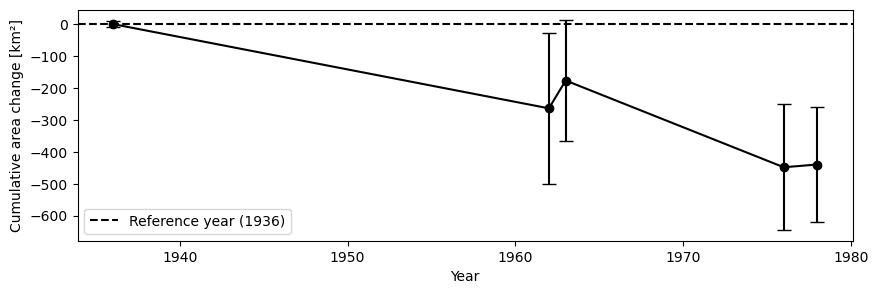

In [174]:
fig, ax = plt.subplots(figsize=[10, 3])

# Create a 2D array from positions_cl using front_id as rows and year as columns, values as mean_corrected
front_ids = np.sort(positions_cl.dropna(subset=["mean_corrected"]).front_id.unique())
years = np.sort(positions_cl.dropna(subset=["mean_corrected"]).year.unique())
l = np.full((len(front_ids), len(years)), 0.)
w = np.full((len(front_ids), len(years)), 0.) # E(Wi^2)

front_id_to_idx = {fid: i for i, fid in enumerate(front_ids)}
year_to_idx = {y: i for i, y in enumerate(years)}
    
for _, row in positions_cl.dropna(subset=["mean_corrected"]).iterrows():
    i = front_id_to_idx[row.front_id]
    j = year_to_idx[row.year]
    l[i, j] = row.mean_corrected**2
    
for _, row in positions_cl.dropna(subset=["mean_corrected"]).iterrows():
    id, year = row.front_id, row.year
    i = front_id_to_idx[id]
    j = year_to_idx[year]
    w[i, j] = all_fronts.loc[all_fronts.front_id == id].loc[all_fronts.year == year].geometry.apply(lambda x: x.length**2).mean()

ul = (uncertainties_cl_single.sigma.values)**2 # V(Di)
uw = (all_fronts.loc[all_fronts.front_id.isin(front_ids)].groupby(["front_id"]).geometry.apply(lambda x: x.apply(lambda y: y.length).std()))**2 # V(Wi)
print(l.shape, ul.shape, w.shape, uw.shape)

ul_mesh, w_mesh = np.meshgrid(ul, w)
err1 = (ul_mesh * w_mesh).sum(axis=0)
# print(err1)

uw_stack = np.array([uw for _ in range(l.shape[1])]).T
err2 = (l * uw_stack).sum(axis=0)
err = 2 * np.sqrt(err1 + err2)/1e6

# print(err2)
print(err)

x = sum_glaciers_cl.index.values.astype(int)
y = sum_glaciers_cl.values.astype(float)/1e6

ax.plot(x, y, marker="o", linestyle="-", color="k", linewidth=1.5)
ax.errorbar(x, y, yerr=err, fmt='o', color='k', markersize=3, capsize=5)
ax.axhline(y=0, color="k", linestyle="--", linewidth=1.5, label="Reference year (1936)")

ax.set_xlabel("Year")
ax.set_ylabel("Cumulative area change [km²]")
ax.legend()
fig.savefig("images/mean_glacier_front_area_cl.png", bbox_inches="tight")

In [175]:
lr = scipy.stats.linregress(x, y)
lr.slope, lr.rvalue**2

(-10.82132150989675, 0.9255607394191009)

In [176]:
y, err

(array([   0.        , -263.95470726, -176.8431312 , -448.41343194,
        -439.84969795]),
 array([  8.60974681, 236.3600492 , 188.77391956, 197.15904898,
        180.26795986]))

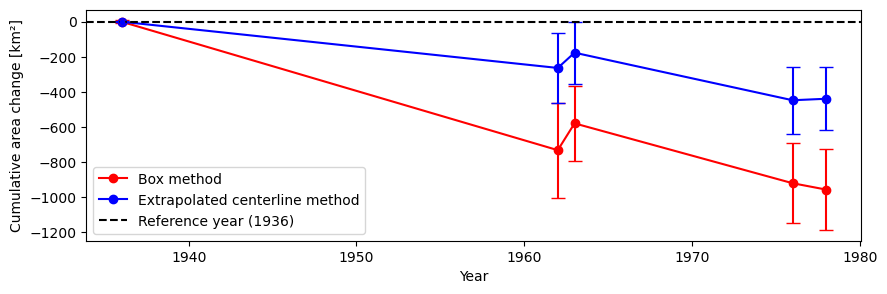

In [177]:
fig, ax = plt.subplots(figsize=[10, 3])

# box
front_ids = np.sort(positions_box.dropna(subset=["mean_corrected"]).front_id.unique())
years = np.sort(positions_box.dropna(subset=["mean_corrected"]).year.unique())
l = np.full((len(front_ids), len(years)), 0.)
w = np.full((len(front_ids), len(years)), 0.) # E(Wi^2)
front_id_to_idx = {fid: i for i, fid in enumerate(front_ids)}
year_to_idx = {y: i for i, y in enumerate(years)}
for _, row in positions_box.dropna(subset=["mean_corrected"]).iterrows():
    i = front_id_to_idx[row.front_id]
    j = year_to_idx[row.year]
    l[i, j] = row.mean_corrected**2
for _, row in positions_box.dropna(subset=["mean_corrected"]).iterrows():
    id, year = row.front_id, row.year
    i = front_id_to_idx[id]
    j = year_to_idx[year]
    w[i, j] = all_fronts.loc[all_fronts.front_id == id].loc[all_fronts.year == year].geometry.apply(lambda x: x.length**2).mean()
ul = (uncertainties_box_single.sigma.values)**2 # V(Di)
uw = (all_fronts.loc[all_fronts.front_id.isin(front_ids)].groupby(["front_id"]).geometry.apply(lambda x: x.apply(lambda y: y.length).std()))**2 # V(Wi)
ul_mesh, w_mesh = np.meshgrid(ul, w)
err1 = (ul_mesh * w_mesh).sum(axis=0)
uw_stack = np.array([uw for _ in range(l.shape[1])]).T
err2 = (l * uw_stack).sum(axis=0)
err = 2 * np.sqrt(err1 + err2)
x = sum_glaciers_box.index.values.astype(int)
y = sum_glaciers_box.values.astype(float)/1e6

ax.plot(x, y, marker="o", linestyle="-", color="r", linewidth=1.5, label="Box method")
ax.errorbar(x, y, yerr=err/1e6, fmt='o', color='r', markersize=3, capsize=5)

# centerline
front_ids = np.sort(positions_cl.dropna(subset=["mean_corrected"]).front_id.unique())
years = np.sort(positions_cl.dropna(subset=["mean_corrected"]).year.unique())
l = np.full((len(front_ids), len(years)), 0.)
w = np.full((len(front_ids), len(years)), 0.) # E(Wi^2)
front_id_to_idx = {fid: i for i, fid in enumerate(front_ids)}
year_to_idx = {y: i for i, y in enumerate(years)}
for _, row in positions_cl.dropna(subset=["mean_corrected"]).iterrows():
    i = front_id_to_idx[row.front_id]
    j = year_to_idx[row.year]
    l[i, j] = row.mean_corrected**2
for _, row in positions_cl.dropna(subset=["mean_corrected"]).iterrows():
    id, year = row.front_id, row.year
    i = front_id_to_idx[id]
    j = year_to_idx[year]
    w[i, j] = all_fronts.loc[all_fronts.front_id == id].loc[all_fronts.year == year].geometry.apply(lambda x: x.length**2).mean()
ul = (uncertainties_cl_single.sigma.values)**2 # V(Di)
w = (all_fronts.loc[all_fronts.front_id.isin(front_ids)].groupby("front_id").geometry.apply(lambda x: x.apply(lambda y: y.length**2).mean())) # E(Wi^2)
uw = (all_fronts.loc[all_fronts.front_id.isin(front_ids)].groupby(["front_id"]).geometry.apply(lambda x: x.apply(lambda y: y.length).std()))**2 # V(Wi)
ul_mesh, w_mesh = np.meshgrid(ul, w)
err1 = (ul_mesh * w_mesh).sum(axis=0)
uw_stack = np.array([uw for _ in range(l.shape[1])]).T
err2 = (l * uw_stack).sum(axis=0)
err = 2 * np.sqrt(err1 + err2)/1e6
x = sum_glaciers_cl.index.values.astype(int)
y = sum_glaciers_cl.values.astype(float)/1e6

ax.plot(x, y, marker="o", linestyle="-", color="b", linewidth=1.5, label="Extrapolated centerline method")
ax.errorbar(x, y, yerr=err, fmt='o', color='b', markersize=3, capsize=5)


ax.axhline(y=0, color="k", linestyle="--", linewidth=1.5, label="Reference year (1936)")
ax.set_xlabel("Year")
ax.set_ylabel("Cumulative area change [km²]")
ax.legend()
fig.savefig("images/mean_glacier_front_area_both.png", bbox_inches="tight")

#### Identification of specific events

In [178]:
def get_year(timestamp):
    return timestamp.year

results_cl = pd.DataFrame(
    [],
    columns = ["front_id", "year_1", "year_2", "distance"]
)
total_count = 0
skip_count = 0
years = [1936, 1962, 1963, 1976, 1978]

for front in all_fronts.front_id.unique():
    # compare observations from any year to fronts from any other year, for a specific front.
    for i_year in range(len(years) - 1):
        year = years[i_year]
        fronts = all_fronts.loc[all_fronts.front_id == front].loc[all_fronts.timestamp.apply(get_year) == year]
        for i_other_year in range(i_year + 1, len(years)):
            other_year = years[i_other_year]
            other_fronts = all_fronts.loc[all_fronts.front_id == front].loc[all_fronts.timestamp.apply(get_year) == other_year]
            
            dists = []
            # compare all the observations between them
            for k in range(len(fronts.geometry)):
                for l in range(len(other_fronts.geometry)):
                    front1 = fronts.geometry.iloc[k]
                    front2 = other_fronts.geometry.iloc[l]
                    dir_1 = fronts.front_dir.iloc[k]
                    dir_2 = other_fronts.front_dir.iloc[l]
                    try:
                        if not centerlines.loc[centerlines.front_id == fronts.front_id.iloc[k]].empty:
                            cl = centerlines.loc[centerlines.front_id == fronts.front_id.iloc[k]].geometry.values[0]
                            dist, e = distances.curvilinear_distance(front1, front2, cl, dir_1, dir_2)
                            if dist is not None:
                                dists.append(dist)
                            elif e == 1:
                                skip_count += 1
                        else:
                            skip_count += 1
                    except AssertionError:
                        skip_count += 1
                    total_count += 1
            
            if not dists == []:
                # horrible hack to load an array as a value in a DataFrame
                results_i = pd.DataFrame(
                    [[front, year, other_year, np.array(dists)]],
                    columns=["front_id", "year_1", "year_2", "distance"]
                )      
            else: # load None instead of a list of distances
                results_i = pd.DataFrame(
                    [[front, year, other_year, None]],
                    columns=["front_id", "year_1", "year_2", "distance"]
                )
            results_cl = pd.concat([results_cl, results_i])
            
print(f"Skipped {skip_count} comparisons out of {total_count}.")
results_cl.reset_index(drop=True, inplace=True)
results_cl = results_cl.dropna().reset_index(drop=True)


results_cl.loc[:, "mean_distance"] = results_cl.distance.apply(lambda x: np.array(x).mean())
results_cl.loc[:, "uncertainty"] = results_cl.loc[:, ["year_1", "year_2"]].apply(lambda x: uncertainties_cl.loc[(uncertainties_cl.year_1 == x.iloc[0]) & (uncertainties_cl.year_2 == x.iloc[1]), "2_sigma_dist"].values[0], axis=1)

# not necessary but easier to control results : put the years in a single column. 
results_cl.loc[:, "years"] = results_cl.loc[:, ["year_1", "year_2"]].apply(lambda x: (x.iloc[0], x.iloc[1]), axis=1)
results_cl = results_cl[["front_id", "year_1", "year_2", "years", "distance", "mean_distance", "uncertainty"]]

results_cl

Skipped 265 comparisons out of 2967.


,front_id,year_1,year_2,years,distance,mean_distance,uncertainty
0,161,1936,1962,"(1936, 1962)","[5097.906156000923, 5641.342097406612, 6250.41...",5602.419256,721.223960
1,161,1936,1963,"(1936, 1963)","[4965.027501024719, 4234.287078158059]",4599.657290,364.428319
2,161,1936,1976,"(1936, 1976)","[5494.7887219228705, 4317.307583836629, 3853.9...",4555.360565,269.295377
3,161,1936,1978,"(1936, 1978)",[3948.6331903453593],3948.633190,146.164291
4,161,1962,1963,"(1962, 1963)","[-132.87865497620442, -863.6190778428645, -676...",-1002.761966,805.880884
...,...,...,...,...,...,...,...
901,165,1962,1978,"(1962, 1978)","[15.071804548701039, 191.13998030281437, -1355...",-38.710959,733.484833
902,165,1976,1978,"(1976, 1978)","[223.52141239179764, 158.60220187543382]",191.061807,300.592748
903,166,1962,1978,"(1962, 1978)","[1310.5165657619164, -163.40075476422317, -104...",-723.127668,733.484833
904,168,1962,1978,"(1962, 1978)","[663.9661815896998, -114.47799319638034, -1216...",-298.260430,733.484833


115 -0.9150941934987639 1.5894266312188523
82 -0.9174740815827481 1.6259681709979918
143 -0.9941509464327883 1.7299929804799667
100 -1.0863638876276724 1.857421418435876
60 -0.0482481700726458 0.27979533496692055
107 -0.22732215143351645 0.7622716554313852
80 -0.23199597226316762 0.903370178851464
72 -0.1568448670663619 0.8380439317301446
54 -0.12171333497438432 0.9496145300907706
93 -0.05717542134490561 0.18055058412139147


C:\Users\loris\AppData\Local\Temp\ipykernel_10856\2444334880.py:170: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[i, j].set_yticklabels(axs[i, j].get_yticks().astype(int))
C:\Users\loris\AppData\Local\Temp\ipykernel_10856\2444334880.py:170: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[i, j].set_yticklabels(axs[i, j].get_yticks().astype(int))
C:\Users\loris\AppData\Local\Temp\ipykernel_10856\2444334880.py:170: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[i, j].set_yticklabels(axs[i, j].get_yticks().astype(int))
C:\Users\loris\AppData\Local\Temp\ipykernel_10856\2444334880.py:170: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[i, j].set_ytic

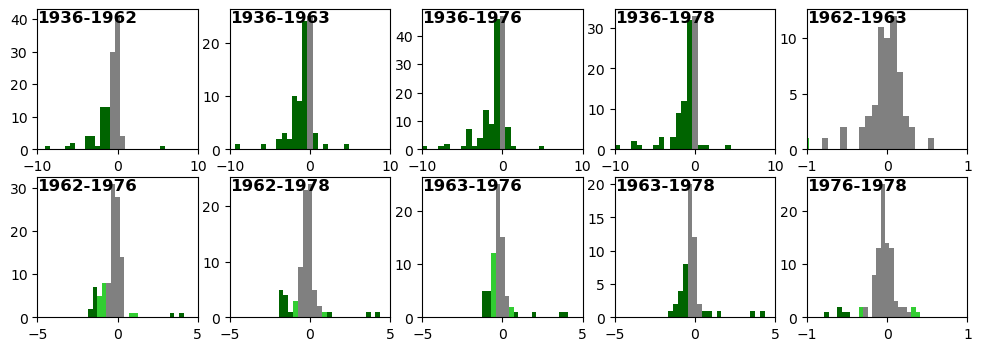

In [179]:
fig, axs = plt.subplots(ncols=5, nrows=2, figsize=(12, 4))

color_sigma = "gray"
color_2_sigma = "limegreen"
color_3_sigma = "darkgreen"
nbins = 30

years = (1936, 1962)
d = results_cl.loc[results_cl.years == years].mean_distance/1e3
N, bins, patches = axs[0, 0].hist(d, color="gray", bins=np.linspace(-np.abs(d).max(), np.abs(d).max(), nbins))
sigma = uncertainties_cl.loc[uncertainties_cl.years == years]["sigma_dist"].values[0]/1e3
bins = np.array(bins) + (bins[1] - bins[0])/2  # shift bins to the center
for i in range(len(patches)):
    if np.abs(bins[i]) >= sigma:
        patches[i].set_facecolor(color_sigma)
    if np.abs(bins[i]) >= 2 * sigma:
        patches[i].set_facecolor(color_2_sigma)
    if np.abs(bins[i]) >= 3 * sigma:
        patches[i].set_facecolor(color_3_sigma)
axs[0, 0].set_title(f"{years[0]}-{years[1]}", y=0.85, loc="left", fontweight="semibold")
axs[0, 0].set_xlim(-10, 10)
print(d.shape[0], d.mean(), d.std())

years = (1936, 1963)
d = results_cl.loc[results_cl.years == years].mean_distance/1e3
N, bins, patches = axs[0, 1].hist(d, color="gray", bins=np.linspace(-np.abs(d).max(), np.abs(d).max(), nbins))
sigma = uncertainties_cl.loc[uncertainties_cl.years == years]["sigma_dist"].values[0]/1e3
bins = np.array(bins) + (bins[1] - bins[0])/2  # shift bins to the center
for i in range(len(patches)):
    if np.abs(bins[i]) >= sigma:
        patches[i].set_facecolor(color_sigma)
    if np.abs(bins[i]) >= 2 * sigma:
        patches[i].set_facecolor(color_2_sigma)
    if np.abs(bins[i]) >= 3 * sigma:
        patches[i].set_facecolor(color_3_sigma)
axs[0, 1].set_title(f"{years[0]}-{years[1]}", y=0.85, loc="left", fontweight="semibold")
axs[0, 1].set_xlim(-10, 10)
print(d.shape[0], d.mean(), d.std())

years = (1936, 1976)
d = results_cl.loc[results_cl.years == years].mean_distance/1e3
N, bins, patches = axs[0, 2].hist(d, color="gray", bins=np.linspace(-np.abs(d).max(), np.abs(d).max(), nbins))
sigma = uncertainties_cl.loc[uncertainties_cl.years == years]["sigma_dist"].values[0]/1e3
bins = np.array(bins) + (bins[1] - bins[0])/2  # shift bins to the center
for i in range(len(patches)):
    if np.abs(bins[i]) >= sigma:
        patches[i].set_facecolor(color_sigma)
    if np.abs(bins[i]) >= 2 * sigma:
        patches[i].set_facecolor(color_2_sigma)
    if np.abs(bins[i]) >= 3 * sigma:
        patches[i].set_facecolor(color_3_sigma)
axs[0, 2].set_title(f"{years[0]}-{years[1]}", y=0.85, loc="left", fontweight="semibold")
axs[0, 2].set_xlim(-10, 10)
print(d.shape[0], d.mean(), d.std())

years = (1936, 1978)
d = results_cl.loc[results_cl.years == years].mean_distance/1e3
N, bins, patches = axs[0, 3].hist(d, color="gray", bins=np.linspace(-np.abs(d).max(), np.abs(d).max(), nbins))
sigma = uncertainties_cl.loc[uncertainties_cl.years == years]["sigma_dist"].values[0]/1e3
bins = np.array(bins) + (bins[1] - bins[0])/2  # shift bins to the center
for i in range(len(patches)):
    if np.abs(bins[i]) >= sigma:
        patches[i].set_facecolor(color_sigma)
    if np.abs(bins[i]) >= 2 * sigma:
        patches[i].set_facecolor(color_2_sigma)
    if np.abs(bins[i]) >= 3 * sigma:
        patches[i].set_facecolor(color_3_sigma)
axs[0, 3].set_title(f"{years[0]}-{years[1]}", y=0.85, loc="left", fontweight="semibold")
axs[0, 3].set_xlim(-10, 10)
print(d.shape[0], d.mean(), d.std())

years = (1962, 1963)
d = results_cl.loc[results_cl.years == years].mean_distance/1e3
N, bins, patches = axs[0, 4].hist(d, color="gray", bins=np.linspace(-np.abs(d).max(), np.abs(d).max(), nbins))
sigma = uncertainties_cl.loc[uncertainties_cl.years == years]["sigma_dist"].values[0]/1e3
bins = np.array(bins) + (bins[1] - bins[0])/2  # shift bins to the center
for i in range(len(patches)):
    if np.abs(bins[i]) >= sigma:
        patches[i].set_facecolor(color_sigma)
    if np.abs(bins[i]) >= 2 * sigma:
        patches[i].set_facecolor(color_2_sigma)
    if np.abs(bins[i]) >= 3 * sigma:
        patches[i].set_facecolor(color_3_sigma)
axs[0, 4].set_title(f"{years[0]}-{years[1]}", y=0.85, loc="left", fontweight="semibold")
axs[0, 4].set_xlim(-1, 1)
print(d.shape[0], d.mean(), d.std())
        
years = (1962, 1976)
d = results_cl.loc[results_cl.years == years].mean_distance/1e3
N, bins, patches = axs[1, 0].hist(d, color="gray", bins=np.linspace(-np.abs(d).max(), np.abs(d).max(), nbins))
sigma = uncertainties_cl.loc[uncertainties_cl.years == years]["sigma_dist"].values[0]/1e3
bins = np.array(bins) + (bins[1] - bins[0])/2
for i in range(len(patches)):
    if np.abs(bins[i]) >= sigma:
        patches[i].set_facecolor(color_sigma)
    if np.abs(bins[i]) >= 2 * sigma:
        patches[i].set_facecolor(color_2_sigma)
    if np.abs(bins[i]) >= 3 * sigma:
        patches[i].set_facecolor(color_3_sigma)
axs[1, 0].set_title(f"{years[0]}-{years[1]}", y=0.85, loc="left", fontweight="semibold")
axs[1, 0].set_xlim(-5, 5)
print(d.shape[0], d.mean(), d.std())
        
years = (1962, 1978)
d = results_cl.loc[results_cl.years == years].mean_distance/1e3
N, bins, patches = axs[1, 1].hist(d, color="gray", bins=np.linspace(-np.abs(d).max(), np.abs(d).max(), nbins))
sigma = uncertainties_cl.loc[uncertainties_cl.years == years]["sigma_dist"].values[0]/1e3
bins = np.array(bins) + (bins[1] - bins[0])/2
for i in range(len(patches)):
    if np.abs(bins[i]) >= sigma:
        patches[i].set_facecolor(color_sigma)
    if np.abs(bins[i]) >= 2 * sigma:
        patches[i].set_facecolor(color_2_sigma)
    if np.abs(bins[i]) >= 3 * sigma:
        patches[i].set_facecolor(color_3_sigma)
axs[1, 1].set_title(f"{years[0]}-{years[1]}", y=0.85, loc="left", fontweight="semibold")
axs[1, 1].set_xlim(-5, 5)
print(d.shape[0], d.mean(), d.std())
        
years = (1963, 1976)
d = results_cl.loc[results_cl.years == years].mean_distance/1e3
N, bins, patches = axs[1, 2].hist(d, color="gray", bins=np.linspace(-np.abs(d).max(), np.abs(d).max(), nbins))
sigma = uncertainties_cl.loc[uncertainties_cl.years == years]["sigma_dist"].values[0]/1e3
bins = np.array(bins) + (bins[1] - bins[0])/2
for i in range(len(patches)):
    if np.abs(bins[i]) >= sigma:
        patches[i].set_facecolor(color_sigma)
    if np.abs(bins[i]) >= 2 * sigma:
        patches[i].set_facecolor(color_2_sigma)
    if np.abs(bins[i]) >= 3 * sigma:
        patches[i].set_facecolor(color_3_sigma)
axs[1, 2].set_title(f"{years[0]}-{years[1]}", y=0.85, loc="left", fontweight="semibold")
axs[1, 2].set_xlim(-5, 5)
print(d.shape[0], d.mean(), d.std())
        
years = (1963, 1978)
d = results_cl.loc[results_cl.years == years].mean_distance/1e3
N, bins, patches = axs[1, 3].hist(d, color="gray", bins=np.linspace(-np.abs(d).max(), np.abs(d).max(), nbins))
sigma = uncertainties_cl.loc[uncertainties_cl.years == years]["sigma_dist"].values[0]/1e3
bins = np.array(bins) + (bins[1] - bins[0])/2
for i in range(len(patches)):
    if np.abs(bins[i]) >= sigma:
        patches[i].set_facecolor(color_sigma)
    if np.abs(bins[i]) >= 2 * sigma:
        patches[i].set_facecolor(color_2_sigma)
    if np.abs(bins[i]) >= 3 * sigma:
        patches[i].set_facecolor(color_3_sigma)
axs[1, 3].set_title(f"{years[0]}-{years[1]}", y=0.85, loc="left", fontweight="semibold")
axs[1, 3].set_xlim(-5, 5)
print(d.shape[0], d.mean(), d.std())
        
years = (1976, 1978)
d = results_cl.loc[results_cl.years == years].mean_distance/1e3
N, bins, patches = axs[1, 4].hist(d, color="gray", bins=np.linspace(-np.abs(d).max(), np.abs(d).max(), nbins))
sigma = uncertainties_cl.loc[uncertainties_cl.years == years]["sigma_dist"].values[0]/1e3
bins = np.array(bins) + (bins[1] - bins[0])/2
for i in range(len(patches)):
    if np.abs(bins[i]) >= sigma:
        patches[i].set_facecolor(color_sigma)
    if np.abs(bins[i]) >= 2 * sigma:
        patches[i].set_facecolor(color_2_sigma)
    if np.abs(bins[i]) >= 3 * sigma:
        patches[i].set_facecolor(color_3_sigma)
axs[1, 4].set_title(f"{years[0]}-{years[1]}", y=0.85, loc="left", fontweight="semibold")
axs[1, 4].set_xlim(-1, 1)
print(d.shape[0], d.mean(), d.std())

for i in range(2):
    for j in range(5):
        axs[i, j].set_yticklabels(axs[i, j].get_yticks().astype(int))
fig.savefig("images/results_distances_distributions_cl_with_NPI.png", bbox_inches="tight")

In [180]:
# list of surges and retreats

surges_cl = pd.DataFrame(
    [],
    columns=["front_id", "years", "mean_distance", "uncertainty"]
)

retreats_cl = pd.DataFrame(
    [],
    columns=["front_id", "years", "mean_distance", "uncertainty"]
)

for years in [(1936, 1962),
              (1936, 1963),
              (1936, 1976),
              (1936, 1978),
              (1962, 1963), 
              (1962, 1976), 
              (1962, 1978), 
              (1963, 1976), 
              (1963, 1978), 
              (1976, 1978)]:
    # print("years :", years)
    sigma = uncertainties_cl.loc[uncertainties_cl.years == years]["sigma_dist"].values[0]
    res = results_cl.where(results_cl.loc[results_cl.years == years, "mean_distance"].apply(lambda x: np.abs(x) >= 2 * sigma)).dropna().loc[:, ["front_id", "years", "mean_distance", "uncertainty"]]
    # print(res)
    surges_1 = res.where(res.mean_distance.apply(lambda x: x >= 0)).dropna()
    retreats_1 = res.where(res.mean_distance.apply(lambda x: x < 0)).dropna()
    if not surges_1.empty:
        surges_cl = pd.concat([surges_cl, surges_1])
    if not retreats_1.empty:
        retreats_cl = pd.concat([retreats_cl, retreats_1])
        
surges_cl

C:\Users\loris\AppData\Local\Temp\ipykernel_10856\776502126.py:30: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  surges_cl = pd.concat([surges_cl, surges_1])
C:\Users\loris\AppData\Local\Temp\ipykernel_10856\776502126.py:32: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  retreats_cl = pd.concat([retreats_cl, retreats_1])


,front_id,years,mean_distance,uncertainty
0,161,"(1936, 1962)",5602.419256,721.223960
401,4,"(1936, 1962)",746.378206,721.223960
1,161,"(1936, 1963)",4599.657290,364.428319
208,50,"(1936, 1963)",916.000154,364.428319
407,3,"(1936, 1963)",450.353008,364.428319
519,139,"(1936, 1963)",682.043100,364.428319
563,141,"(1936, 1963)",1664.599870,364.428319
2,161,"(1936, 1976)",4555.360565,269.295377
34,153,"(1936, 1976)",902.134163,269.295377
190,172,"(1936, 1976)",407.391229,269.295377


In [181]:
retreats_cl

,front_id,years,mean_distance,uncertainty
41,63,"(1936, 1962)",-3587.140196,721.223960
47,62,"(1936, 1962)",-6101.944455,721.223960
53,73,"(1936, 1962)",-805.346490,721.223960
59,69,"(1936, 1962)",-1886.712005,721.223960
74,68,"(1936, 1962)",-1496.277892,721.223960
...,...,...,...,...
152,93,"(1976, 1978)",-617.914969,300.592748
161,89,"(1976, 1978)",-785.803758,300.592748
167,61,"(1976, 1978)",-340.517014,300.592748
173,74,"(1976, 1978)",-477.872500,300.592748


In [182]:
# list of all fronts that either surged or retreated with >95% accuracy
len(surges_cl.front_id.unique()), surges_cl.front_id.unique(), len(retreats_cl.front_id.unique()), retreats_cl.front_id.unique()

(21,
 array([161, 4, 50, 3, 139, 141, 153, 172, 174, 125, 122, 123, 175, 64,
        121, 120, 93, 92, 56, 91, 163], dtype=object),
 122,
 array([63, 62, 73, 69, 68, 70, 100, 99, 98, 97, 96, 60, 61, 74, 105, 95,
        180, 75, 51, 52, 39, 54, 31, 30, 109, 111, 140, 106, 107, 108, 122,
        120, 123, 57, 56, 76, 42, 59, 58, 121, 138, 103, 101, 49, 93, 92,
        41, 53, 38, 33, 27, 114, 115, 178, 94, 28, 35, 46, 47, 48, 181, 91,
        110, 150, 152, 160, 67, 66, 71, 72, 79, 65, 89, 90, 40, 34, 137,
        32, 29, 21, 14, 1, 4, 6, 5, 136, 127, 112, 113, 142, 8, 9, 12, 37,
        2, 15, 17, 19, 22, 24, 55, 78, 82, 88, 119, 143, 145, 144, 86, 87,
        80, 81, 83, 154, 43, 84, 116, 124, 158, 161, 50, 141], dtype=object))

## Comparison methods

In [183]:
# for i in results_cl.index.values:
#     front_id, year1, year2 = results_cl.loc[i][["front_id", "year_1", "year_2"]]
#     for j in results_box.index.values:
#         front_id_2, year1_2, year2_2 = results_box.loc[j][["front_id", "year_1", "year_2"]]
#         if (front_id == front_id_2) and (year1 == year1_2) and (year2 == year2_2):
#             results_cl.loc[i, "mean_distance_2"] = results_box.loc[j, "mean_distance"]
#             results_cl.loc[i, "uncertainty_2"] = results_box.loc[j, "uncertainty"]
            
# results_cl

In [184]:
# results_cross = results_cl.loc[:, ["front_id", "year_1", "year_2", "years", "mean_distance", "mean_distance_2", "uncertainty", "uncertainty_2"]]
# results_cross.columns = ["front_id", "year_1", "year_2", "years", "mean_distance_cl", "mean_distance_box", "uncertainty_cl", "uncertainty_box"]
# results_cross.dropna(inplace=True)
# results_cross

In [185]:
# lr = scipy.stats.linregress(
#     results_cross.mean_distance_cl,
#     results_cross.mean_distance_box
# )
# lr.slope, lr.rvalue, lr.intercept

In [186]:
positions_box_0, positions_cl_0 = positions_box.loc[positions_box.mean_corrected != 0], positions_cl.loc[positions_cl.mean_corrected != 0]

for i in positions_box_0.index.values:
    front_id, year = positions_box_0.loc[i][["front_id", "year"]]
    for j in positions_cl_0.index.values:
        front_id_2, year_2 = positions_cl_0.loc[j][["front_id", "year"]]
        if (front_id == front_id_2) and (year == year_2):
            positions_box_0.loc[i, "mean_corrected_cl"] = positions_cl_0.loc[j, "mean_corrected"]
            positions_box_0.loc[i, "uncertainty_cl"] = positions_cl_0.loc[j, "uncertainty"]

C:\Users\loris\AppData\Local\Temp\ipykernel_10856\3250777008.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positions_box_0.loc[i, "mean_corrected_cl"] = positions_cl_0.loc[j, "mean_corrected"]
C:\Users\loris\AppData\Local\Temp\ipykernel_10856\3250777008.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positions_box_0.loc[i, "uncertainty_cl"] = positions_cl_0.loc[j, "uncertainty"]


In [187]:
results_cross = positions_box_0.loc[:, ["front_id", "year", "mean_corrected", "mean_corrected_cl", "uncertainty", "uncertainty_cl"]]
results_cross.columns = ["front_id", "year", "mean_corrected_box", "mean_corrected_cl", "uncertainty_box", "uncertainty_cl"]
results_cross.dropna(inplace=True)
results_cross

,front_id,year,mean_corrected_box,mean_corrected_cl,uncertainty_box,uncertainty_cl
1,1,1962,132.352507,113.380798,500,360.0
2,1,1963,-217.196958,-168.838573,215,181.0
3,1,1976,-640.102399,-430.585457,96,133.0
4,1,1978,-590.87054,-454.992206,98,70.0
6,2,1962,29.199247,186.621011,500,360.0
...,...,...,...,...,...,...
650,179,1976,14.839713,-5.899516,96,133.0
652,180,1962,-1703.263221,-1268.970911,500,360.0
653,180,1963,-1922.797861,-1481.116313,215,181.0
654,180,1976,-2549.576724,-2028.614637,96,133.0


In [188]:
mean_box = results_cross.mean_corrected_box.mean()
mean_cl = results_cross.mean_corrected_cl.mean()
std_box = results_cross.mean_corrected_box.std()
std_cl = results_cross.mean_corrected_cl.std()
for i in results_cross.index.values:
    if results_cross.loc[i, "mean_corrected_box"] - mean_box > 3 * std_box or results_cross.loc[i, "mean_corrected_box"] - mean_box < -3 * std_box:
        results_cross.loc[i, "mean_corrected_box"] = np.nan
    if results_cross.loc[i, "mean_corrected_cl"] - mean_cl > 3 * std_cl or results_cross.loc[i, "mean_corrected_cl"] - mean_cl < -3 * std_cl:
        results_cross.loc[i, "mean_corrected_cl"] = np.nan
        
results_cross.dropna(inplace=True)
print(len(results_cross))

372


In [189]:
lr = scipy.stats.linregress(
    results_cross.mean_corrected_cl.values.astype(float),
    results_cross.mean_corrected_box.values.astype(float)
)
lr.slope, lr.rvalue, lr.intercept

(1.3253597499137661, 0.9226583473761895, -122.44730818544599)

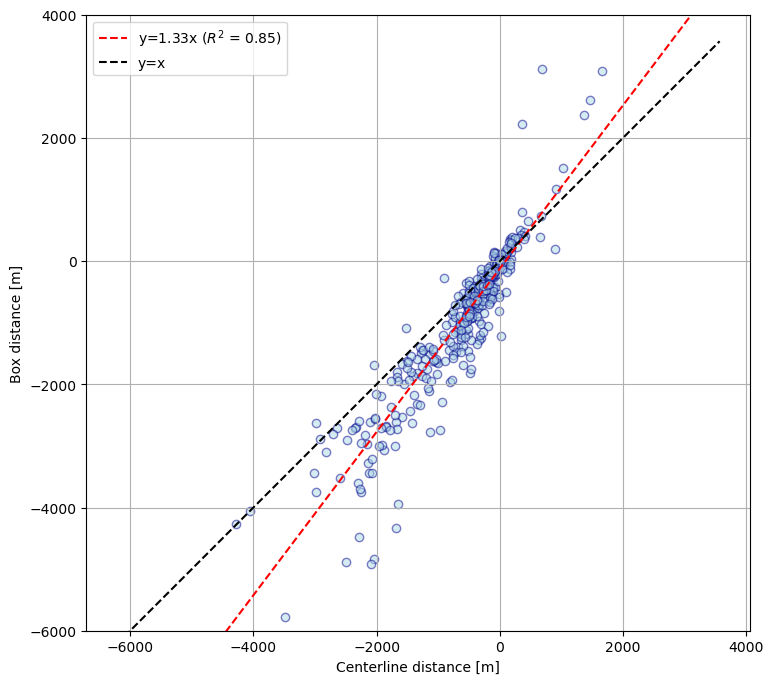

In [192]:
fig, ax = plt.subplots(figsize=(11, 8))
ax.scatter(results_cross.mean_corrected_cl, results_cross.mean_corrected_box, color="lightblue", edgecolor="darkblue", alpha=0.5)
xlim = ax.get_xlim()
ylim = ax.get_ylim()
x_vals = np.linspace(min(xlim[0], ylim[0]), max(xlim[1], ylim[1]), 100)
ax.plot(x_vals, lr.slope * x_vals + lr.intercept, color ="r", linestyle="--", label=f"y={lr.slope:.2f}x ($R^2$ = {lr.rvalue**2:.2f})")
# ax.text(-3500, -6700, f"$R^2$ = {lr.rvalue**2:.2f}", fontsize=14, color="r", verticalalignment="top", horizontalalignment="left")
ax.plot(x_vals, x_vals, color="k", linestyle="--", label="y=x")

ax.grid()
ax.legend()
ax.set_xlabel("Centerline distance [m]")
ax.set_ylabel("Box distance [m]")
ax.set_ylim([-5000, 4000])
ax.set_aspect("equal")
ax.set_yticks(np.arange(-6000, 5000, 2000))
fig.savefig("images/results_cross_distances.png", bbox_inches="tight")

## Chose specific events

In [ ]:
surges = surges_box.copy()

for i in surges_box.index.values:
    for j in surges_cl.index.values:
        if (surges_box.front_id.loc[i] == surges_cl.front_id.loc[j]) and (surges_box.years.loc[i] == surges_cl.years.loc[j]):
            surges.loc[i, "mean_distance_cl"] = surges_cl.loc[j, "mean_distance"]
            surges.loc[i, "uncertainty_cl"] = surges_cl.loc[j, "uncertainty"]

surges.dropna(inplace=True)
surges.sort_values(by=["front_id", "years"], inplace=True)
surges

,front_id,years,mean_distance,uncertainty,mean_distance_cl,uncertainty_cl
362,3,"(1936, 1963)",658.621812,432.046294,450.353008,364.428319
175,50,"(1936, 1963)",1163.262446,432.046294,916.000154,364.428319
176,50,"(1936, 1976)",500.015784,196.540072,330.922213,269.295377
177,50,"(1936, 1978)",338.016990,200.449495,183.967934,146.164291
557,56,"(1963, 1976)",1159.852106,470.918252,604.320288,449.221549
558,56,"(1963, 1978)",997.568851,472.563223,537.684511,388.128845
700,64,"(1936, 1978)",225.225877,200.449495,278.518380,146.164291
713,91,"(1963, 1976)",775.398523,470.918252,491.067425,449.221549
135,92,"(1963, 1976)",1823.102178,470.918252,774.150989,449.221549
136,92,"(1963, 1978)",1439.942271,472.563223,994.493179,388.128845


In [ ]:
retreats = retreats_box.copy()

for i in retreats_box.index.values:
    for j in retreats_cl.index.values:
        if retreats_box.front_id.loc[i] == retreats_cl.front_id.loc[j] and retreats_box.years.loc[i] == retreats_cl.years.loc[j]:
            retreats.loc[i, "mean_distance_cl"] = retreats_cl.loc[j, "mean_distance"]
            retreats.loc[i, "uncertainty_cl"] = retreats_cl.loc[j, "uncertainty"]

retreats.dropna(inplace=True)
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    display(retreats.sort_values(by=["front_id", "years"], ascending=True))

,front_id,years,mean_distance,uncertainty,mean_distance_cl,uncertainty_cl
351,1,"(1936, 1976)",-640.102399,196.540072,-430.585457,269.295377
352,1,"(1936, 1978)",-590.870540,200.449495,-454.992206,146.164291
599,2,"(1936, 1976)",-636.434686,196.540072,-333.864938,269.295377
600,2,"(1936, 1978)",-786.380870,200.449495,-487.522317,146.164291
605,2,"(1963, 1978)",-655.872948,472.563223,-476.914327,388.128845
360,4,"(1936, 1976)",-857.784306,196.540072,-777.042861,269.295377
361,4,"(1963, 1976)",-776.636692,470.918252,-721.383682,449.221549
369,5,"(1936, 1976)",-982.297992,196.540072,-774.149618,269.295377
366,6,"(1936, 1976)",-847.815286,196.540072,-524.247106,269.295377
560,8,"(1936, 1976)",-907.153501,196.540072,-727.968950,269.295377


In [ ]:
retreats.front_id.unique().shape

(112,)

In [ ]:
len(surges_box), len(surges_cl)

(37, 44)

In [ ]:
len(retreats_box), len(retreats_cl)

(336, 340)

In [ ]:
len(surges), len(retreats)

(29, 272)